In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import h5py
from PIL import Image
import os
import tqdm

In [2]:
# download nyu depth v2 dataset
# !python -m wget http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat

(480, 640, 3) uint8
(480, 640) float32


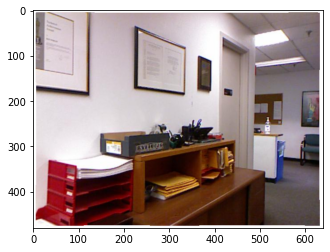

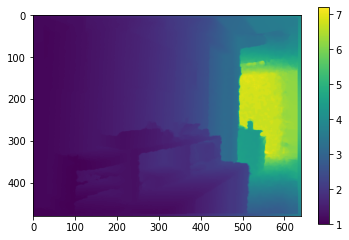

In [4]:
# read nyu depth v2 dataset
fn = "images/nyu_depth_v2_labeled.mat"
f = h5py.File(fn)

# This dataset consists of 1449 pairs of RGB and depth images
# Here we get the 9-th sample
img = f['images'][8].T
depth = f['depths'][8].T

# print the shape of each array
print(img.shape, img.dtype)
print(depth.shape, depth.dtype)

# visualize these images
plt.imshow(img)
plt.show()
plt.imshow(depth)
plt.colorbar()
plt.show()

In [5]:
# An RGB image has 3-channels (red, green, and blur), and the type of each channel is 8bit unsigned int, i.e, the range is from 0 to 255.
# change the type to float 32-bit and the range from 0 to 1 for deep learning
img = img.astype(np.float32) / 255

In [6]:
from skimage.transform import resize

# function to resize and crop an input image
def resize_and_crop(img, resize_height, resize_width, crop_height, crop_width) :
  # resize
  resized = resize(img, (resize_height,resize_width))
  # crop
  h0 = (resized.shape[0] - crop_height) // 2
  w0 = (resized.shape[1] - crop_width) // 2
  cropped = resized[h0:h0+crop_height, w0:w0+crop_width] 
  return cropped

In [5]:
# from google.colab import drive
# drive.mount('/content/ots_beta')

(96, 128, 3)


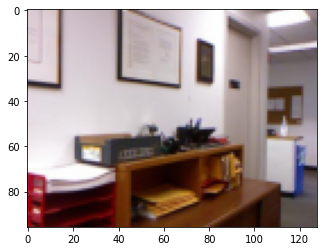

(96, 128)


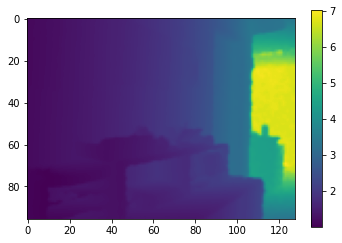

In [7]:
img2 = resize_and_crop(img, 120, 160, 96, 128)
print(img2.shape)
plt.imshow(img2)
plt.show()

depth2 = resize_and_crop(depth, 120, 160, 96, 128)
print(depth2.shape)
plt.imshow(depth2)
plt.colorbar()
plt.show()

In [8]:
def synthesize_foggy_image(img, depth, A, beta):
  # atmospheric scattering model
  # I = J * t + A * (1 - t)
  # t = exp^{-beta * depth}

  # coding
  match_depth = np.zeros_like(img)

  # Match image shape
  match_depth[:,:,0] = depth
  match_depth[:,:,1] = depth
  match_depth[:,:,2] = depth

  # Model
  J = img
  t = np.exp(-beta * match_depth)
  I = J * t + A * (1 - t)

  # Return result
  foggy_img = I
  return foggy_img

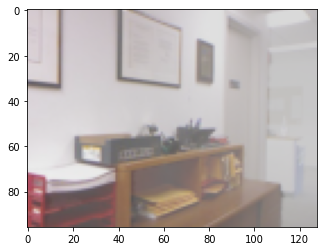

In [9]:
foggy_img = synthesize_foggy_image(img2, depth2, 0.8, 0.4)
plt.imshow(foggy_img)
plt.show()

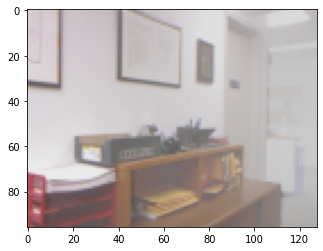

In [10]:
# save the synthesized image
# convert the data type to unsigned int 8bit
# here, the file name is 000001.png
Image.fromarray((foggy_img*255).astype(np.uint8)).save("{:06}.png".format(1))

# load image
foggy_img = np.array(Image.open("000001.png"))
plt.imshow(foggy_img)
plt.show()

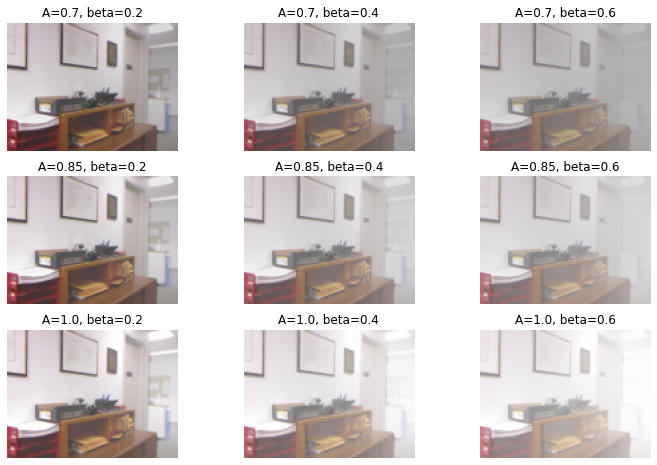

In [11]:
# change parameters (A and beta)
A = [0.7, 0.85, 1.0]
beta = [0.2, 0.4, 0.6]

fig = plt.figure(figsize=(12, 8))
axes = fig.subplots(len(A), len(beta))
for axis in axes.flatten():
    axis.set_axis_off() 
for i in range(len(A)):
  for j in range(len(beta)):
    foggy_img = synthesize_foggy_image(img2, depth2, A[i], beta[j])
    axes[i][j].imshow(foggy_img)
    axes[i][j].set_title("A=" + str(A[i]) + ", beta=" + str(beta[j]))
plt.show()

In [31]:
# prepare directories for dataset
def create_dir(path):
  if not os.path.exists(path):
    os.mkdir(path)

# create_dir("images/dataset")
# create_dir("images/dataset/train")
# create_dir("images/dataset/train/clear")
# create_dir("images/dataset/train/foggy")
# create_dir("images/dataset/test")
# create_dir("images/dataset/test/clear")
# create_dir("images/dataset/test/foggy")

In [32]:
# apply the above process to all images (0-1448)
# for each image, randomly generate 10 patters of A and beta
# First 100 images are for test, and the other 1349 images are for training
# please create the dataset as follows.
# "dataset/train/clear/******.png" correponds to the clear version of  "dataset/train/foggy/******.png"
# dataset
# ├── train
# │     ├── clear
# │     │    ├── 000000.png
# │     │    │      :
# │     │    └── 013489.png
# │     └── foggy
# │           ├── 000000.png
# │           │      :
# │           └── 013489.png
# └── test
#        ├── clear
#        │    ├── 000000.png
#        │    │      :
#        │    └── 000999.png
#        └── foggy
#              ├── 000000.png
#              │      :
#              └── 000999.png


import random

# range of A
A_range = (0.7, 1.0)
# range of beta
beta_range = (0.2, 0.6)

# coding
img_count = 0
set_count = 0
dir_clear = "images/dataset/test/clear/"
dir_foggy = "images/dataset/test/foggy/"
for i in range(len(f['images'])):

  # Get images
  img = f['images'][i].T
  depth = f['depths'][i].T

  # Resize and crop
  img2 = resize_and_crop(img, 120, 160, 96, 128)
  depth2 = resize_and_crop(depth, 120, 160, 96, 128)
  
  # Generate 10 random
  for j in range(10):

    # Apply fog
    A = random.uniform(0.7, 1.0)
    beta = random.uniform(0.2, 0.6)
    foggy_img = synthesize_foggy_image(img2, depth2, A, beta)

    # Save images
    filename = "{:06}.png".format(set_count)
    # Image.fromarray((img2*255).astype(np.uint8)).save(dir_clear+filename)
    # Image.fromarray((foggy_img*255).astype(np.uint8)).save(dir_foggy+filename)
    img_count = img_count + 1
    set_count = img_count
    print(filename)

    # Proceed to add to train directory
    if img_count > 999:
      dir_clear = "images/dataset/train/clear/"
      dir_foggy = "images/dataset/train/foggy/"
      set_count = img_count - 1000

000000.png
000001.png
000002.png
000003.png
000004.png
000005.png
000006.png
000007.png
000008.png
000009.png
000010.png
000011.png
000012.png
000013.png
000014.png
000015.png
000016.png
000017.png
000018.png
000019.png
000020.png
000021.png
000022.png
000023.png
000024.png
000025.png
000026.png
000027.png
000028.png
000029.png
000030.png
000031.png
000032.png
000033.png
000034.png
000035.png
000036.png
000037.png
000038.png
000039.png
000040.png
000041.png
000042.png
000043.png
000044.png
000045.png
000046.png
000047.png
000048.png
000049.png
000050.png
000051.png
000052.png
000053.png
000054.png
000055.png
000056.png
000057.png
000058.png
000059.png
000060.png
000061.png
000062.png
000063.png
000064.png
000065.png
000066.png
000067.png
000068.png
000069.png
000070.png
000071.png
000072.png
000073.png
000074.png
000075.png
000076.png
000077.png
000078.png
000079.png
000080.png
000081.png
000082.png
000083.png
000084.png
000085.png
000086.png
000087.png
000088.png
000089.png
000090.png

000770.png
000771.png
000772.png
000773.png
000774.png
000775.png
000776.png
000777.png
000778.png
000779.png
000780.png
000781.png
000782.png
000783.png
000784.png
000785.png
000786.png
000787.png
000788.png
000789.png
000790.png
000791.png
000792.png
000793.png
000794.png
000795.png
000796.png
000797.png
000798.png
000799.png
000800.png
000801.png
000802.png
000803.png
000804.png
000805.png
000806.png
000807.png
000808.png
000809.png
000810.png
000811.png
000812.png
000813.png
000814.png
000815.png
000816.png
000817.png
000818.png
000819.png
000820.png
000821.png
000822.png
000823.png
000824.png
000825.png
000826.png
000827.png
000828.png
000829.png
000830.png
000831.png
000832.png
000833.png
000834.png
000835.png
000836.png
000837.png
000838.png
000839.png
000840.png
000841.png
000842.png
000843.png
000844.png
000845.png
000846.png
000847.png
000848.png
000849.png
000850.png
000851.png
000852.png
000853.png
000854.png
000855.png
000856.png
000857.png
000858.png
000859.png
000860.png

000550.png
000551.png
000552.png
000553.png
000554.png
000555.png
000556.png
000557.png
000558.png
000559.png
000560.png
000561.png
000562.png
000563.png
000564.png
000565.png
000566.png
000567.png
000568.png
000569.png
000570.png
000571.png
000572.png
000573.png
000574.png
000575.png
000576.png
000577.png
000578.png
000579.png
000580.png
000581.png
000582.png
000583.png
000584.png
000585.png
000586.png
000587.png
000588.png
000589.png
000590.png
000591.png
000592.png
000593.png
000594.png
000595.png
000596.png
000597.png
000598.png
000599.png
000600.png
000601.png
000602.png
000603.png
000604.png
000605.png
000606.png
000607.png
000608.png
000609.png
000610.png
000611.png
000612.png
000613.png
000614.png
000615.png
000616.png
000617.png
000618.png
000619.png
000620.png
000621.png
000622.png
000623.png
000624.png
000625.png
000626.png
000627.png
000628.png
000629.png
000630.png
000631.png
000632.png
000633.png
000634.png
000635.png
000636.png
000637.png
000638.png
000639.png
000640.png

001310.png
001311.png
001312.png
001313.png
001314.png
001315.png
001316.png
001317.png
001318.png
001319.png
001320.png
001321.png
001322.png
001323.png
001324.png
001325.png
001326.png
001327.png
001328.png
001329.png
001330.png
001331.png
001332.png
001333.png
001334.png
001335.png
001336.png
001337.png
001338.png
001339.png
001340.png
001341.png
001342.png
001343.png
001344.png
001345.png
001346.png
001347.png
001348.png
001349.png
001350.png
001351.png
001352.png
001353.png
001354.png
001355.png
001356.png
001357.png
001358.png
001359.png
001360.png
001361.png
001362.png
001363.png
001364.png
001365.png
001366.png
001367.png
001368.png
001369.png
001370.png
001371.png
001372.png
001373.png
001374.png
001375.png
001376.png
001377.png
001378.png
001379.png
001380.png
001381.png
001382.png
001383.png
001384.png
001385.png
001386.png
001387.png
001388.png
001389.png
001390.png
001391.png
001392.png
001393.png
001394.png
001395.png
001396.png
001397.png
001398.png
001399.png
001400.png

002091.png
002092.png
002093.png
002094.png
002095.png
002096.png
002097.png
002098.png
002099.png
002100.png
002101.png
002102.png
002103.png
002104.png
002105.png
002106.png
002107.png
002108.png
002109.png
002110.png
002111.png
002112.png
002113.png
002114.png
002115.png
002116.png
002117.png
002118.png
002119.png
002120.png
002121.png
002122.png
002123.png
002124.png
002125.png
002126.png
002127.png
002128.png
002129.png
002130.png
002131.png
002132.png
002133.png
002134.png
002135.png
002136.png
002137.png
002138.png
002139.png
002140.png
002141.png
002142.png
002143.png
002144.png
002145.png
002146.png
002147.png
002148.png
002149.png
002150.png
002151.png
002152.png
002153.png
002154.png
002155.png
002156.png
002157.png
002158.png
002159.png
002160.png
002161.png
002162.png
002163.png
002164.png
002165.png
002166.png
002167.png
002168.png
002169.png
002170.png
002171.png
002172.png
002173.png
002174.png
002175.png
002176.png
002177.png
002178.png
002179.png
002180.png
002181.png

002870.png
002871.png
002872.png
002873.png
002874.png
002875.png
002876.png
002877.png
002878.png
002879.png
002880.png
002881.png
002882.png
002883.png
002884.png
002885.png
002886.png
002887.png
002888.png
002889.png
002890.png
002891.png
002892.png
002893.png
002894.png
002895.png
002896.png
002897.png
002898.png
002899.png
002900.png
002901.png
002902.png
002903.png
002904.png
002905.png
002906.png
002907.png
002908.png
002909.png
002910.png
002911.png
002912.png
002913.png
002914.png
002915.png
002916.png
002917.png
002918.png
002919.png
002920.png
002921.png
002922.png
002923.png
002924.png
002925.png
002926.png
002927.png
002928.png
002929.png
002930.png
002931.png
002932.png
002933.png
002934.png
002935.png
002936.png
002937.png
002938.png
002939.png
002940.png
002941.png
002942.png
002943.png
002944.png
002945.png
002946.png
002947.png
002948.png
002949.png
002950.png
002951.png
002952.png
002953.png
002954.png
002955.png
002956.png
002957.png
002958.png
002959.png
002960.png

003621.png
003622.png
003623.png
003624.png
003625.png
003626.png
003627.png
003628.png
003629.png
003630.png
003631.png
003632.png
003633.png
003634.png
003635.png
003636.png
003637.png
003638.png
003639.png
003640.png
003641.png
003642.png
003643.png
003644.png
003645.png
003646.png
003647.png
003648.png
003649.png
003650.png
003651.png
003652.png
003653.png
003654.png
003655.png
003656.png
003657.png
003658.png
003659.png
003660.png
003661.png
003662.png
003663.png
003664.png
003665.png
003666.png
003667.png
003668.png
003669.png
003670.png
003671.png
003672.png
003673.png
003674.png
003675.png
003676.png
003677.png
003678.png
003679.png
003680.png
003681.png
003682.png
003683.png
003684.png
003685.png
003686.png
003687.png
003688.png
003689.png
003690.png
003691.png
003692.png
003693.png
003694.png
003695.png
003696.png
003697.png
003698.png
003699.png
003700.png
003701.png
003702.png
003703.png
003704.png
003705.png
003706.png
003707.png
003708.png
003709.png
003710.png
003711.png

004401.png
004402.png
004403.png
004404.png
004405.png
004406.png
004407.png
004408.png
004409.png
004410.png
004411.png
004412.png
004413.png
004414.png
004415.png
004416.png
004417.png
004418.png
004419.png
004420.png
004421.png
004422.png
004423.png
004424.png
004425.png
004426.png
004427.png
004428.png
004429.png
004430.png
004431.png
004432.png
004433.png
004434.png
004435.png
004436.png
004437.png
004438.png
004439.png
004440.png
004441.png
004442.png
004443.png
004444.png
004445.png
004446.png
004447.png
004448.png
004449.png
004450.png
004451.png
004452.png
004453.png
004454.png
004455.png
004456.png
004457.png
004458.png
004459.png
004460.png
004461.png
004462.png
004463.png
004464.png
004465.png
004466.png
004467.png
004468.png
004469.png
004470.png
004471.png
004472.png
004473.png
004474.png
004475.png
004476.png
004477.png
004478.png
004479.png
004480.png
004481.png
004482.png
004483.png
004484.png
004485.png
004486.png
004487.png
004488.png
004489.png
004490.png
004491.png

005171.png
005172.png
005173.png
005174.png
005175.png
005176.png
005177.png
005178.png
005179.png
005180.png
005181.png
005182.png
005183.png
005184.png
005185.png
005186.png
005187.png
005188.png
005189.png
005190.png
005191.png
005192.png
005193.png
005194.png
005195.png
005196.png
005197.png
005198.png
005199.png
005200.png
005201.png
005202.png
005203.png
005204.png
005205.png
005206.png
005207.png
005208.png
005209.png
005210.png
005211.png
005212.png
005213.png
005214.png
005215.png
005216.png
005217.png
005218.png
005219.png
005220.png
005221.png
005222.png
005223.png
005224.png
005225.png
005226.png
005227.png
005228.png
005229.png
005230.png
005231.png
005232.png
005233.png
005234.png
005235.png
005236.png
005237.png
005238.png
005239.png
005240.png
005241.png
005242.png
005243.png
005244.png
005245.png
005246.png
005247.png
005248.png
005249.png
005250.png
005251.png
005252.png
005253.png
005254.png
005255.png
005256.png
005257.png
005258.png
005259.png
005260.png
005261.png

005941.png
005942.png
005943.png
005944.png
005945.png
005946.png
005947.png
005948.png
005949.png
005950.png
005951.png
005952.png
005953.png
005954.png
005955.png
005956.png
005957.png
005958.png
005959.png
005960.png
005961.png
005962.png
005963.png
005964.png
005965.png
005966.png
005967.png
005968.png
005969.png
005970.png
005971.png
005972.png
005973.png
005974.png
005975.png
005976.png
005977.png
005978.png
005979.png
005980.png
005981.png
005982.png
005983.png
005984.png
005985.png
005986.png
005987.png
005988.png
005989.png
005990.png
005991.png
005992.png
005993.png
005994.png
005995.png
005996.png
005997.png
005998.png
005999.png
006000.png
006001.png
006002.png
006003.png
006004.png
006005.png
006006.png
006007.png
006008.png
006009.png
006010.png
006011.png
006012.png
006013.png
006014.png
006015.png
006016.png
006017.png
006018.png
006019.png
006020.png
006021.png
006022.png
006023.png
006024.png
006025.png
006026.png
006027.png
006028.png
006029.png
006030.png
006031.png

006691.png
006692.png
006693.png
006694.png
006695.png
006696.png
006697.png
006698.png
006699.png
006700.png
006701.png
006702.png
006703.png
006704.png
006705.png
006706.png
006707.png
006708.png
006709.png
006710.png
006711.png
006712.png
006713.png
006714.png
006715.png
006716.png
006717.png
006718.png
006719.png
006720.png
006721.png
006722.png
006723.png
006724.png
006725.png
006726.png
006727.png
006728.png
006729.png
006730.png
006731.png
006732.png
006733.png
006734.png
006735.png
006736.png
006737.png
006738.png
006739.png
006740.png
006741.png
006742.png
006743.png
006744.png
006745.png
006746.png
006747.png
006748.png
006749.png
006750.png
006751.png
006752.png
006753.png
006754.png
006755.png
006756.png
006757.png
006758.png
006759.png
006760.png
006761.png
006762.png
006763.png
006764.png
006765.png
006766.png
006767.png
006768.png
006769.png
006770.png
006771.png
006772.png
006773.png
006774.png
006775.png
006776.png
006777.png
006778.png
006779.png
006780.png
006781.png

007451.png
007452.png
007453.png
007454.png
007455.png
007456.png
007457.png
007458.png
007459.png
007460.png
007461.png
007462.png
007463.png
007464.png
007465.png
007466.png
007467.png
007468.png
007469.png
007470.png
007471.png
007472.png
007473.png
007474.png
007475.png
007476.png
007477.png
007478.png
007479.png
007480.png
007481.png
007482.png
007483.png
007484.png
007485.png
007486.png
007487.png
007488.png
007489.png
007490.png
007491.png
007492.png
007493.png
007494.png
007495.png
007496.png
007497.png
007498.png
007499.png
007500.png
007501.png
007502.png
007503.png
007504.png
007505.png
007506.png
007507.png
007508.png
007509.png
007510.png
007511.png
007512.png
007513.png
007514.png
007515.png
007516.png
007517.png
007518.png
007519.png
007520.png
007521.png
007522.png
007523.png
007524.png
007525.png
007526.png
007527.png
007528.png
007529.png
007530.png
007531.png
007532.png
007533.png
007534.png
007535.png
007536.png
007537.png
007538.png
007539.png
007540.png
007541.png

008225.png
008226.png
008227.png
008228.png
008229.png
008230.png
008231.png
008232.png
008233.png
008234.png
008235.png
008236.png
008237.png
008238.png
008239.png
008240.png
008241.png
008242.png
008243.png
008244.png
008245.png
008246.png
008247.png
008248.png
008249.png
008250.png
008251.png
008252.png
008253.png
008254.png
008255.png
008256.png
008257.png
008258.png
008259.png
008260.png
008261.png
008262.png
008263.png
008264.png
008265.png
008266.png
008267.png
008268.png
008269.png
008270.png
008271.png
008272.png
008273.png
008274.png
008275.png
008276.png
008277.png
008278.png
008279.png
008280.png
008281.png
008282.png
008283.png
008284.png
008285.png
008286.png
008287.png
008288.png
008289.png
008290.png
008291.png
008292.png
008293.png
008294.png
008295.png
008296.png
008297.png
008298.png
008299.png
008300.png
008301.png
008302.png
008303.png
008304.png
008305.png
008306.png
008307.png
008308.png
008309.png
008310.png
008311.png
008312.png
008313.png
008314.png
008315.png

008970.png
008971.png
008972.png
008973.png
008974.png
008975.png
008976.png
008977.png
008978.png
008979.png
008980.png
008981.png
008982.png
008983.png
008984.png
008985.png
008986.png
008987.png
008988.png
008989.png
008990.png
008991.png
008992.png
008993.png
008994.png
008995.png
008996.png
008997.png
008998.png
008999.png
009000.png
009001.png
009002.png
009003.png
009004.png
009005.png
009006.png
009007.png
009008.png
009009.png
009010.png
009011.png
009012.png
009013.png
009014.png
009015.png
009016.png
009017.png
009018.png
009019.png
009020.png
009021.png
009022.png
009023.png
009024.png
009025.png
009026.png
009027.png
009028.png
009029.png
009030.png
009031.png
009032.png
009033.png
009034.png
009035.png
009036.png
009037.png
009038.png
009039.png
009040.png
009041.png
009042.png
009043.png
009044.png
009045.png
009046.png
009047.png
009048.png
009049.png
009050.png
009051.png
009052.png
009053.png
009054.png
009055.png
009056.png
009057.png
009058.png
009059.png
009060.png

009741.png
009742.png
009743.png
009744.png
009745.png
009746.png
009747.png
009748.png
009749.png
009750.png
009751.png
009752.png
009753.png
009754.png
009755.png
009756.png
009757.png
009758.png
009759.png
009760.png
009761.png
009762.png
009763.png
009764.png
009765.png
009766.png
009767.png
009768.png
009769.png
009770.png
009771.png
009772.png
009773.png
009774.png
009775.png
009776.png
009777.png
009778.png
009779.png
009780.png
009781.png
009782.png
009783.png
009784.png
009785.png
009786.png
009787.png
009788.png
009789.png
009790.png
009791.png
009792.png
009793.png
009794.png
009795.png
009796.png
009797.png
009798.png
009799.png
009800.png
009801.png
009802.png
009803.png
009804.png
009805.png
009806.png
009807.png
009808.png
009809.png
009810.png
009811.png
009812.png
009813.png
009814.png
009815.png
009816.png
009817.png
009818.png
009819.png
009820.png
009821.png
009822.png
009823.png
009824.png
009825.png
009826.png
009827.png
009828.png
009829.png
009830.png
009831.png

010511.png
010512.png
010513.png
010514.png
010515.png
010516.png
010517.png
010518.png
010519.png
010520.png
010521.png
010522.png
010523.png
010524.png
010525.png
010526.png
010527.png
010528.png
010529.png
010530.png
010531.png
010532.png
010533.png
010534.png
010535.png
010536.png
010537.png
010538.png
010539.png
010540.png
010541.png
010542.png
010543.png
010544.png
010545.png
010546.png
010547.png
010548.png
010549.png
010550.png
010551.png
010552.png
010553.png
010554.png
010555.png
010556.png
010557.png
010558.png
010559.png
010560.png
010561.png
010562.png
010563.png
010564.png
010565.png
010566.png
010567.png
010568.png
010569.png
010570.png
010571.png
010572.png
010573.png
010574.png
010575.png
010576.png
010577.png
010578.png
010579.png
010580.png
010581.png
010582.png
010583.png
010584.png
010585.png
010586.png
010587.png
010588.png
010589.png
010590.png
010591.png
010592.png
010593.png
010594.png
010595.png
010596.png
010597.png
010598.png
010599.png
010600.png
010601.png

011260.png
011261.png
011262.png
011263.png
011264.png
011265.png
011266.png
011267.png
011268.png
011269.png
011270.png
011271.png
011272.png
011273.png
011274.png
011275.png
011276.png
011277.png
011278.png
011279.png
011280.png
011281.png
011282.png
011283.png
011284.png
011285.png
011286.png
011287.png
011288.png
011289.png
011290.png
011291.png
011292.png
011293.png
011294.png
011295.png
011296.png
011297.png
011298.png
011299.png
011300.png
011301.png
011302.png
011303.png
011304.png
011305.png
011306.png
011307.png
011308.png
011309.png
011310.png
011311.png
011312.png
011313.png
011314.png
011315.png
011316.png
011317.png
011318.png
011319.png
011320.png
011321.png
011322.png
011323.png
011324.png
011325.png
011326.png
011327.png
011328.png
011329.png
011330.png
011331.png
011332.png
011333.png
011334.png
011335.png
011336.png
011337.png
011338.png
011339.png
011340.png
011341.png
011342.png
011343.png
011344.png
011345.png
011346.png
011347.png
011348.png
011349.png
011350.png

012041.png
012042.png
012043.png
012044.png
012045.png
012046.png
012047.png
012048.png
012049.png
012050.png
012051.png
012052.png
012053.png
012054.png
012055.png
012056.png
012057.png
012058.png
012059.png
012060.png
012061.png
012062.png
012063.png
012064.png
012065.png
012066.png
012067.png
012068.png
012069.png
012070.png
012071.png
012072.png
012073.png
012074.png
012075.png
012076.png
012077.png
012078.png
012079.png
012080.png
012081.png
012082.png
012083.png
012084.png
012085.png
012086.png
012087.png
012088.png
012089.png
012090.png
012091.png
012092.png
012093.png
012094.png
012095.png
012096.png
012097.png
012098.png
012099.png
012100.png
012101.png
012102.png
012103.png
012104.png
012105.png
012106.png
012107.png
012108.png
012109.png
012110.png
012111.png
012112.png
012113.png
012114.png
012115.png
012116.png
012117.png
012118.png
012119.png
012120.png
012121.png
012122.png
012123.png
012124.png
012125.png
012126.png
012127.png
012128.png
012129.png
012130.png
012131.png

012791.png
012792.png
012793.png
012794.png
012795.png
012796.png
012797.png
012798.png
012799.png
012800.png
012801.png
012802.png
012803.png
012804.png
012805.png
012806.png
012807.png
012808.png
012809.png
012810.png
012811.png
012812.png
012813.png
012814.png
012815.png
012816.png
012817.png
012818.png
012819.png
012820.png
012821.png
012822.png
012823.png
012824.png
012825.png
012826.png
012827.png
012828.png
012829.png
012830.png
012831.png
012832.png
012833.png
012834.png
012835.png
012836.png
012837.png
012838.png
012839.png
012840.png
012841.png
012842.png
012843.png
012844.png
012845.png
012846.png
012847.png
012848.png
012849.png
012850.png
012851.png
012852.png
012853.png
012854.png
012855.png
012856.png
012857.png
012858.png
012859.png
012860.png
012861.png
012862.png
012863.png
012864.png
012865.png
012866.png
012867.png
012868.png
012869.png
012870.png
012871.png
012872.png
012873.png
012874.png
012875.png
012876.png
012877.png
012878.png
012879.png
012880.png
012881.png

In [33]:
# import deep learning framework, pytorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [34]:
# An image is represented by a 4-dimensional tensor
# size of minibatch x channels x height x width
# This is a dummy image, the size of which is 4(size of minibatch) x 3(RGB) x 128(height) x 128(width)
x = torch.zeros(4, 3, 128, 128)
print(x.shape)

torch.Size([4, 3, 128, 128])


In [35]:
# define convolution filter
# here, input channel is 3, output channel is 32, and filter size is 3 x 3
conv = nn.Conv2d(3, 32, 3)

In [36]:
# convoluve the dummy image
y = conv(x)

# output channel is 32
print(y.shape)

torch.Size([4, 32, 126, 126])


In [37]:
# exmaple of padding=1
conv_pad = nn.Conv2d(3, 32, 3, padding=1)
y = conv_pad(x)

# output has the same size (128x128)
# padding with the size (filter_size-1)/2 leads to the same output size
print(y.shape)

torch.Size([4, 32, 128, 128])


In [38]:
# example of stride
conv_pad_stride = nn.Conv2d(3, 32, 3, padding=1, stride=2)
y = conv_pad_stride(x)

# output size is halved (64x64)
print(y.shape)

torch.Size([4, 32, 64, 64])


In [39]:
# this is an example of 2-layers CNN
# each convolution layer decreases the image size, while the channels are increased.
# an activation fucntion follows each convolution
net = nn.Sequential(
    nn.Conv2d(3, 32, 3, padding=1, stride=2),
    nn.ReLU(), # activation function
    nn.Conv2d(32, 64, 3, padding=1, stride=2),
    nn.ReLU()
    )

y = net(x)

# This CNN leads to the output with the shape 4x64x32x32
print(y.shape)

torch.Size([4, 64, 32, 32])


In [40]:
# For this defogging example, input shape is batch_size x 3 x 96 x 128, and output should have the same shape (batch_size x 3 x 96 x 128)
# We use upsample and convolution to increase the size of convolved images.
# Final layer has sigmoid activation, which limits the output value between 0 to 1.
# This is the example of 4-layers CNN (the encoder and decoder has 2-layers, respectively)
net = nn.Sequential(
    # decrease image size (encoder)
    nn.Conv2d(3, 32, 3, padding=1, stride=2),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, padding=1, stride=2),
    nn.ReLU(),
    # increase image size (decoder)
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
    nn.Conv2d(64, 32, 3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
    nn.Conv2d(32, 3, 3, padding=1),
    nn.Sigmoid() # sigmoid activation
    )

y = net(x)

# the output has the same shape as the input
print(y.shape)

torch.Size([4, 3, 128, 128])


In [41]:
# Let's implement a 10-layers CNN (5-layers encoder and 5-layers decoder)
net = nn.Sequential(
    # encoder
    nn.Conv2d(3, 32, 3, padding=1, stride=2),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, padding=1, stride=2),
    nn.ReLU(),
    nn.Conv2d(64, 128, 3, padding=1, stride=2),
    nn.ReLU(),
    nn.Conv2d(128, 256, 3, padding=1, stride=2),
    nn.ReLU(),
    nn.Conv2d(256, 512, 3, padding=1, stride=2),
    nn.ReLU(),
    # decoder
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
    nn.Conv2d(512, 256, 3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
    nn.Conv2d(256, 128, 3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
    nn.Conv2d(128, 64, 3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
    nn.Conv2d(64, 32, 3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
    nn.Conv2d(32, 3, 3, padding=1),
    nn.Sigmoid() # sigmoid activation
)

y = net(x)

print(y.shape)

torch.Size([4, 3, 128, 128])


In [42]:
# Note that this simple network will not work well.
# For better results, U-net is implemented at the end of this exercise code.

In [43]:
net.to("cuda") # put the network on GPU

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): ReLU()
  (10): Upsample(scale_factor=2.0, mode=bilinear)
  (11): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU()
  (13): Upsample(scale_factor=2.0, mode=bilinear)
  (14): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): Upsample(scale_factor=2.0, mode=bilinear)
  (17): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU()
  (19): Upsample(scale_factor=2.0, mode=bilinear)
  (20): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (

In [44]:
# functions for training

# load paramerters
def load_params(model, filename):
  params = torch.load(filename)
  model.load_state_dict(params)

# save parameters
def save_params(model, filename):
  params = model.state_dict()
  torch.save(params, filename, pickle_protocol=4)

# train the network
def train(net, train_dataset, test_dataset, epoch0=0, epoch_num=20, loss_fn=nn.MSELoss(), optimizer_cls=optim.Adam, lr=1e-4, out_dir=None):
  
  if out_dir is not None:
    create_dir(out_dir)
  else:
    out_dir = "output/out"
    create_dir(out_dir)

  train_losses = []
  test_losses = []
  optimizer = optimizer_cls(net.parameters(), lr=lr)

  # when restarting training
  if epoch0 != 0:
    load_params(net, os.path.join(out_dir, "epoch_{:03}.pth".format(epoch0)))
    load_params(optimizer, os.path.join(out_dir, "optim_epoch_{:03}.pth".format(epoch0)))
    train_losses = np.load(os.path.join(out_dir, "train_loss_epoch_{:03}.npy".format(epoch0))).tolist()
    test_losses = np.load(os.path.join(out_dir, "test_loss_epoch_{:03}.npy".format(epoch0))).tolist()

  # the number of training epochs is epoch_num
  for epoch in range(epoch0, epoch_num):
    running_loss = 0
    # set training mode
    # this is because some layers have different behavior at training and test times, e.g., batch normalization.
    net.train()
    
    with tqdm.tqdm(train_loader) as pbar:
      # extract minibatch from the dataset
      for i, data in enumerate(pbar):
          clear_img = data[0]
          foggy_img = data[1]
          
          # N x H x W x C => N x C x H x W
          clear_img = clear_img.transpose(2,3).transpose(1,2).to("cuda") # N x 3 x H x W
          foggy_img = foggy_img.transpose(2,3).transpose(1,2).to("cuda") # N x 3 x H x W
          
          pred = net(foggy_img) # estimate
          loss = loss_fn(pred, clear_img) # compute loss
          running_loss = (running_loss * i + loss.item()) / (i + 1)
          pbar.set_postfix(MSELoss=running_loss)
          
          # update parameters
          optimizer.zero_grad() # the derivatives of all parameters are set to 0
          loss.backward() # backpropagation to compute the derivatives of all parameters
          optimizer.step() # update the parameters
          
    train_losses.append(running_loss)
    test_losses.append(test(net, test_loader, loss_fn))
    print("\n{}: train_loss = {}, test_loss = {}".format(epoch+1, train_losses[-1], test_losses[-1]))

    save_params(net, os.path.join(out_dir, "epoch_{:03}.pth".format(epoch+1)))
    save_params(optimizer, os.path.join(out_dir, "optim_epoch_{:03}.pth".format(epoch+1)))
    np.save(os.path.join(out_dir, "train_loss_epoch_{:03}".format(epoch+1)), np.array(train_losses))
    np.save(os.path.join(out_dir, "test_loss_epoch_{:03}".format(epoch+1)), np.array(test_losses))
  
  return train_losses, test_losses

# function for test
def test(net, test_dataset, loss_fn):
  # set test mode
  net.eval()
  running_loss = 0
  for data in test_dataset:
    clear_img = data[0]
    foggy_img = data[1]
    
    # N x H x W x C => N x C x H x W
    clear_img = clear_img.transpose(2,3).transpose(1,2).to("cuda") # N x 3 x H x W
    foggy_img = foggy_img.transpose(2,3).transpose(1,2).to("cuda") # N x 3 x H x W

    # At test time, derivatives are not necessary
    with torch.no_grad():
      pred = net(foggy_img)
      loss = loss_fn(pred, clear_img)
      running_loss += loss.item()

  running_loss /= len(test_dataset)
  return running_loss

In [49]:
# define dataset 
class DefogDataset(Dataset):
  def __init__(self, dataset_dir):
    self.dataset_dir = dataset_dir

  def __len__(self):
    return len(os.listdir(os.path.join(self.dataset_dir, "clear")))
    
  def __getitem__(self, idx):
    clear_img = np.array(Image.open(os.path.join(self.dataset_dir, "clear/{:06}.png".format(idx)))).astype(np.float32) / 255.
    foggy_img = np.array(Image.open(os.path.join(self.dataset_dir, "foggy/{:06}.png".format(idx)))).astype(np.float32) / 255.
    return clear_img, foggy_img

train_dataset = DefogDataset("images/dataset/train")
test_dataset = DefogDataset("images/dataset/test")

In [50]:
# set minibatch size
train_batch_size = 16
test_batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=False)

# epoch_num: training epochs
# epoch0: initial epoch when restarting training
# optimizer_cls: update method, e.g., Adam
# lr: learning rate
# Note that the training will takes some time
# train_losses, test_losses = train(net, train_dataset, test_dataset, epoch_num=5, epoch0=0, optimizer_cls=optim.Adam, lr=1e-4)

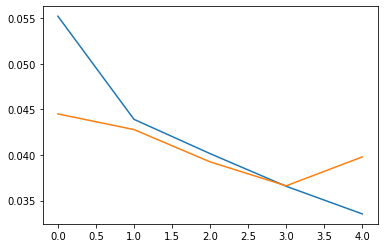

In [51]:
# plot train loss and test loss
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

In [52]:
load_params(net, "output/out/epoch_{:03}.pth".format(5))

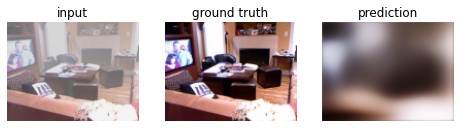

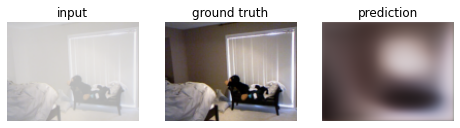

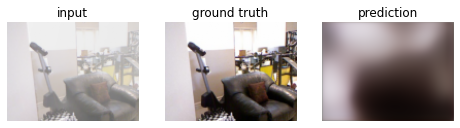

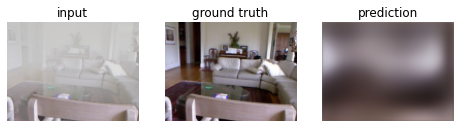

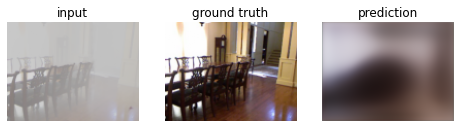

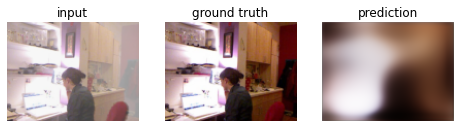

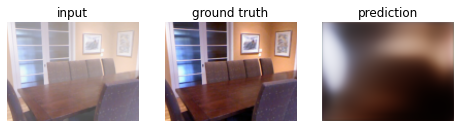

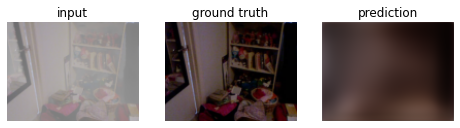

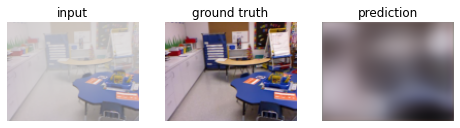

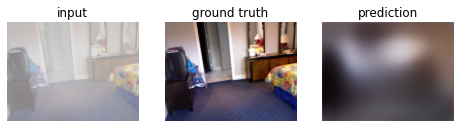

In [53]:
# randomly extract 10 samples from the training dataset

net.eval()

batch_size = 10
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

def tensor2numpy(tensor):
  # gpu tensor (N x C x H x W) => cpu numpy array (N x H x W x C)
  return tensor.transpose(1,2).transpose(2,3).detach().to("cpu").numpy()

for data in loader:
  clear_img = data[0]
  foggy_img = data[1]
          
  clear_img = clear_img.transpose(2,3).transpose(1,2).to("cuda") # N x 3 x H x W
  foggy_img = foggy_img.transpose(2,3).transpose(1,2).to("cuda") # N x 3 x H x W
          
  pred = net(foggy_img)

  for i in range(batch_size):
    fig = plt.figure(figsize=(8, 4))
    axes = fig.subplots(1, 3)
    for axis in axes.flatten():
      axis.set_axis_off()
      
    axes[0].imshow(tensor2numpy(foggy_img)[i])
    axes[0].set_title("input")
    axes[1].imshow(tensor2numpy(clear_img)[i])
    axes[1].set_title("ground truth")
    axes[2].imshow(tensor2numpy(pred)[i])
    axes[2].set_title("prediction")
    plt.show()

  break

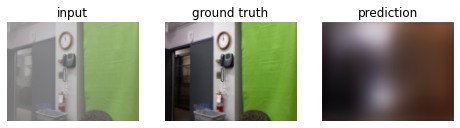

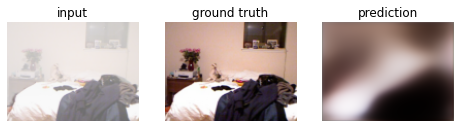

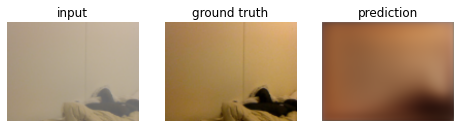

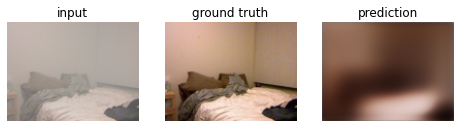

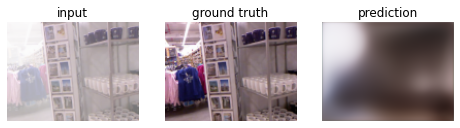

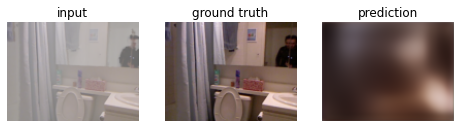

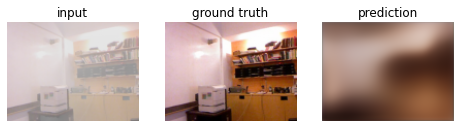

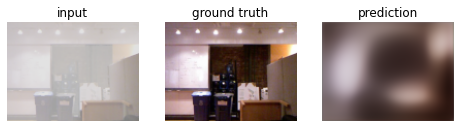

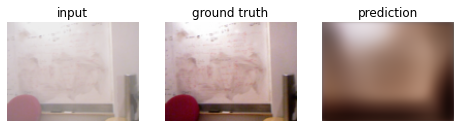

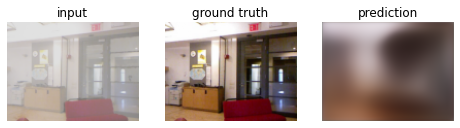

In [54]:
# randomly extract 10 samples from the test dataset

net.eval()

batch_size = 10
loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

def tensor2numpy(tensor):
  # gpu tensor (N x C x H x W) => cpu numpy array (N x H x W x C)
  return tensor.transpose(1,2).transpose(2,3).detach().to("cpu").numpy()

for data in loader:
  clear_img = data[0]
  foggy_img = data[1]
          
  clear_img = clear_img.transpose(2,3).transpose(1,2).to("cuda") # N x 3 x H x W
  foggy_img = foggy_img.transpose(2,3).transpose(1,2).to("cuda") # N x 3 x H x W
          
  pred = net(foggy_img)

  for i in range(batch_size):
    fig = plt.figure(figsize=(8, 4))
    axes = fig.subplots(1, 3)
    for axis in axes.flatten():
      axis.set_axis_off()
      
    axes[0].imshow(tensor2numpy(foggy_img)[i])
    axes[0].set_title("input")
    axes[1].imshow(tensor2numpy(clear_img)[i])
    axes[1].set_title("ground truth")
    axes[2].imshow(tensor2numpy(pred)[i])
    axes[2].set_title("prediction")
    plt.show()

  break

In [55]:
# download actual foggy images
# !python -m wget "https://onedrive.live.com/download?cid=22AA8A9F0CDA7E59&resid=22AA8A9F0CDA7E59%2124872&authkey=ANh7MGyMP-mha6w"

In [97]:
# !tar -zxvf real_foggy_scenes.tar.gz

x real_foggy_scenes/
x real_foggy_scenes/._2.JPG
x real_foggy_scenes/2.JPG
x real_foggy_scenes/._1.JPG
x real_foggy_scenes/1.JPG
x real_foggy_scenes/._0.JPG
x real_foggy_scenes/0.JPG


(1936, 2912, 3)


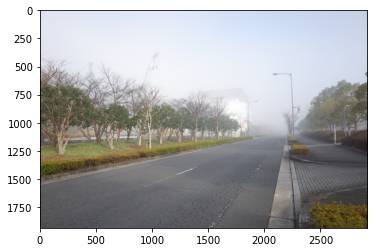

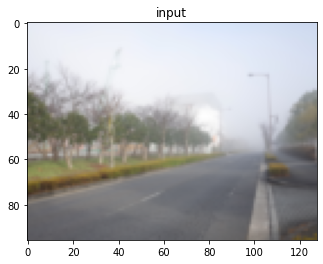

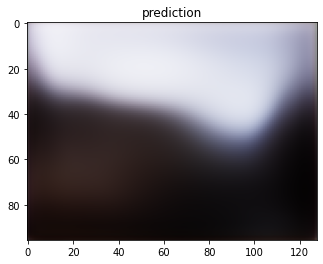

(1936, 2912, 3)


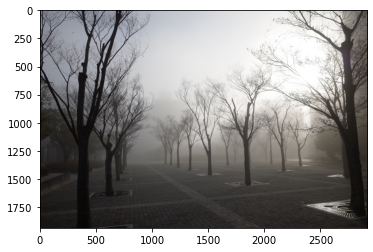

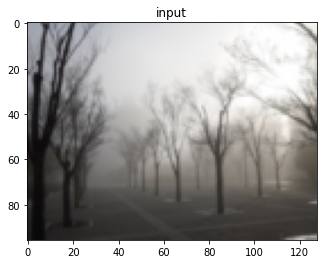

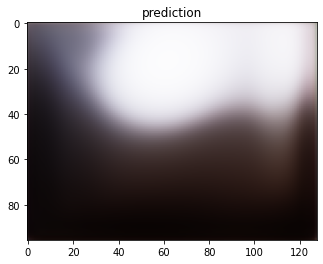

(1936, 2912, 3)


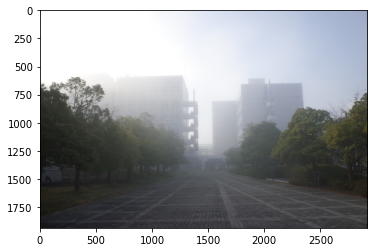

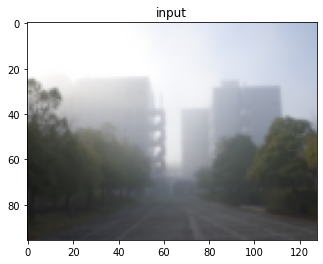

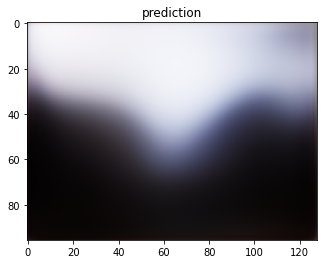

In [57]:
# test on actual foggy images

net.eval()

for i in range(3):
  img = np.array(Image.open("images/real_foggy_scenes/{}.JPG".format(i)))
  print(img.shape)
  plt.imshow(img)
  plt.show()
  
  img = img.astype(np.float32) / 255
  img2 = resize_and_crop(img, 120, 160, 96, 128)
  plt.imshow(img2)
  plt.title("input")
  plt.show()

  x = torch.from_numpy(img2)
  x = x.unsqueeze(0).transpose(2,3).transpose(1,2).to("cuda")
  pred = net(x)
  plt.imshow(tensor2numpy(pred)[0])
  plt.title("prediction")
  plt.show()


### Appendix
- How to improve the performance
  - increase data
    - more scattering parameters to synthesize foggy images
    - data augmentataion (flip image)
    - public dataset
      RESIDE: A Benchmark for Single Image Dehazing
      https://sites.google.com/view/reside-dehaze-datasets/
  - Comlicated network architecture
    - skip connection (U-net)
      - https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
      - The example code is below (this implementation is a little different from the original U-net)
    - ResNet https://arxiv.org/abs/1512.03385v1
- state-of-the-art defogging, dehazing
  - FFA-Net- Feature Fusion Attention Network for Single Image Dehazing, AAAI, 2020.
    - https://github.com/zhilin007/FFA-Net
  - Contrastive Learning for Compact Single Image Dehazing, CVPR, 2021.
    - https://github.com/GlassyWu/AECR-Net
  - PSD: Principled Synthetic-to-Real Dehazing Guided by Physical Priors, CVPR, 2021
    - https://github.com/zychen-ustc/PSD-Principled-Synthetic-to-Real-Dehazing-Guided-by-Physical-Priors

In [59]:
# U-Net
class UNet(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = self.down_conv_layer(3, 64, 7)
    self.conv2 = self.down_conv_layer(64, 128, 5)
    self.conv3 = self.down_conv_layer(128, 256, 3)
    self.conv4 = self.down_conv_layer(256, 512, 3)

    self.upconv3 = self.up_conv_layer(512, 256, 3)
    self.iconv3 = self.conv_layer(512, 256, 3)

    self.upconv2 = self.up_conv_layer(256, 128, 3)
    self.iconv2 = self.conv_layer(256, 128, 3)

    self.upconv1 = self.up_conv_layer(128, 64, 3)
    self.iconv1 = self.conv_layer(128, 64, 3)

    self.upconv0 = self.up_conv_layer(64, 64, 3)
    self.out = nn.Conv2d(64, 3, 3, padding=1)



  def forward(self, x):
    # x: N x 3 x H x W
    conv1 = self.conv1(x) # N x 64 x H/2 x W/2
    conv2 = self.conv2(conv1) # N x 128 x H/4 x W/4
    conv3 = self.conv3(conv2) # N x 256 x H/8 x W/8
    conv4 = self.conv4(conv3) # N x 512 x H/16 x W/16

    upconv3 = self.upconv3(conv4) # N x 256 x H/8 x W/8
    iconv3 = self.iconv3(torch.cat((upconv3, conv3), 1)) # N x 256 x H/8 x W/8

    upconv2 = self.upconv2(iconv3) # N x 128 x H/4 x W/4
    iconv2 = self.iconv2(torch.cat((upconv2, conv2), 1)) # N x 128 x H/4 x W/4

    upconv1 = self.upconv1(iconv2) # N x 64 x H/2 x W/2
    iconv1 = self.iconv1(torch.cat((upconv1, conv1), 1)) # N x 64 x H/2 x W/2

    upconv0 = self.upconv0(iconv1) # N x 64 x H x W
    _out = self.out(upconv0) # N x 3 x H x W
    out = torch.sigmoid(_out)

    return out

  def down_conv_layer(self, in_channels, out_channels, kernel_size):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, padding=int((kernel_size-1)/2)),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size, padding=int((kernel_size-1)/2), stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
        )
    
  def up_conv_layer(self, in_channels, out_channels, kernel_size):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        nn.Conv2d(in_channels, out_channels, kernel_size, padding=int((kernel_size-1)/2)),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
        )

  def conv_layer(self, in_channels, out_channels, kernel_size):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, padding=int((kernel_size-1)/2)),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
        )

In [60]:
net = UNet()
net.to("cuda")

# pre-trained model
# !python -m wget "https://onedrive.live.com/download?cid=22AA8A9F0CDA7E59&resid=22AA8A9F0CDA7E59%2124875&authkey=AFaSJDOxiJYSVKk" 
load_params(net, "pre-trained/unet_pretrained.pth")

In [66]:
# Prepare directories for RESIDE dataset
def create_dir(path):
  if not os.path.exists(path):
    os.mkdir(path)

# create_dir("images/reside_resize_crop")
# create_dir("images/reside_resize_crop/train")
# create_dir("images/reside_resize_crop/train/clear")
# create_dir("images/reside_resize_crop/train/foggy")
# create_dir("images/reside_resize_crop/test")
# create_dir("images/reside_resize_crop/test/clear")
# create_dir("images/reside_resize_crop/test/foggy")

In [ ]:
# Get directory
reside_clear_dir = 'images/ots_beta/clear'
reside_foggy_dir = 'images/ots_beta/haze'

# Set foggy config
foggy_A = ["0.8", "0.9", "0.85", "0.95", "1"] 
foggy_beta = ["0.1", "0.2", "0.04", "0.06", "0.08", "0.12", "0.16"]

# Save image variables
img_count = 0
dir_clear = "images/reside_resize_crop/train/clear/"
dir_foggy = "images/reside_resize_crop/train/foggy/"

# Iterate over files in foggy directory
for filename in os.listdir(reside_clear_dir):
  f = os.path.join(reside_clear_dir, filename)

  # If file is valid print file.
  if os.path.isfile(f):

    # Get clear image and its index
    reside_index = os.path.splitext(filename)[0]
    clear_img = np.array(Image.open(f))

    # Resize and crop
    clear2 = resize_and_crop(clear_img, 120, 160, 96, 128)

    # Loop through A and beta values to get the foggy images
    for reside_A in foggy_A:
      for reside_beta in foggy_beta:

        # Get foggy image filename
        reside_name = reside_index + "_" + reside_A + "_" + reside_beta
        foggy_filename = reside_name + ".jpg";
        foggy_img = np.array(Image.open(reside_foggy_dir + "/" + foggy_filename))
        foggy2 = resize_and_crop(foggy_img, 120, 160, 96, 128)
        print(foggy_filename)

        # Save images
        filename = "{:06}.png".format(img_count)
        # Image.fromarray((clear2*255).astype(np.uint8)).save(dir_clear+filename)
        # Image.fromarray((foggy2*255).astype(np.uint8)).save(dir_foggy+filename)
        img_count = img_count + 1

0025_0.8_0.1.jpg
0025_0.8_0.2.jpg
0025_0.8_0.04.jpg
0025_0.8_0.06.jpg
0025_0.8_0.08.jpg
0025_0.8_0.12.jpg
0025_0.8_0.16.jpg
0025_0.9_0.1.jpg
0025_0.9_0.2.jpg
0025_0.9_0.04.jpg
0025_0.9_0.06.jpg
0025_0.9_0.08.jpg
0025_0.9_0.12.jpg
0025_0.9_0.16.jpg
0025_0.85_0.1.jpg
0025_0.85_0.2.jpg
0025_0.85_0.04.jpg
0025_0.85_0.06.jpg
0025_0.85_0.08.jpg
0025_0.85_0.12.jpg
0025_0.85_0.16.jpg
0025_0.95_0.1.jpg
0025_0.95_0.2.jpg
0025_0.95_0.04.jpg
0025_0.95_0.06.jpg
0025_0.95_0.08.jpg
0025_0.95_0.12.jpg
0025_0.95_0.16.jpg
0025_1_0.1.jpg
0025_1_0.2.jpg
0025_1_0.04.jpg
0025_1_0.06.jpg
0025_1_0.08.jpg
0025_1_0.12.jpg
0025_1_0.16.jpg
0039_0.8_0.1.jpg
0039_0.8_0.2.jpg
0039_0.8_0.04.jpg
0039_0.8_0.06.jpg
0039_0.8_0.08.jpg
0039_0.8_0.12.jpg
0039_0.8_0.16.jpg
0039_0.9_0.1.jpg
0039_0.9_0.2.jpg
0039_0.9_0.04.jpg
0039_0.9_0.06.jpg
0039_0.9_0.08.jpg
0039_0.9_0.12.jpg
0039_0.9_0.16.jpg
0039_0.85_0.1.jpg
0039_0.85_0.2.jpg
0039_0.85_0.04.jpg
0039_0.85_0.06.jpg
0039_0.85_0.08.jpg
0039_0.85_0.12.jpg
0039_0.85_0.16.jpg
0

0138_0.9_0.08.jpg
0138_0.9_0.12.jpg
0138_0.9_0.16.jpg
0138_0.85_0.1.jpg
0138_0.85_0.2.jpg
0138_0.85_0.04.jpg
0138_0.85_0.06.jpg
0138_0.85_0.08.jpg
0138_0.85_0.12.jpg
0138_0.85_0.16.jpg
0138_0.95_0.1.jpg
0138_0.95_0.2.jpg
0138_0.95_0.04.jpg
0138_0.95_0.06.jpg
0138_0.95_0.08.jpg
0138_0.95_0.12.jpg
0138_0.95_0.16.jpg
0138_1_0.1.jpg
0138_1_0.2.jpg
0138_1_0.04.jpg
0138_1_0.06.jpg
0138_1_0.08.jpg
0138_1_0.12.jpg
0138_1_0.16.jpg
0140_0.8_0.1.jpg
0140_0.8_0.2.jpg
0140_0.8_0.04.jpg
0140_0.8_0.06.jpg
0140_0.8_0.08.jpg
0140_0.8_0.12.jpg
0140_0.8_0.16.jpg
0140_0.9_0.1.jpg
0140_0.9_0.2.jpg
0140_0.9_0.04.jpg
0140_0.9_0.06.jpg
0140_0.9_0.08.jpg
0140_0.9_0.12.jpg
0140_0.9_0.16.jpg
0140_0.85_0.1.jpg
0140_0.85_0.2.jpg
0140_0.85_0.04.jpg
0140_0.85_0.06.jpg
0140_0.85_0.08.jpg
0140_0.85_0.12.jpg
0140_0.85_0.16.jpg
0140_0.95_0.1.jpg
0140_0.95_0.2.jpg
0140_0.95_0.04.jpg
0140_0.95_0.06.jpg
0140_0.95_0.08.jpg
0140_0.95_0.12.jpg
0140_0.95_0.16.jpg
0140_1_0.1.jpg
0140_1_0.2.jpg
0140_1_0.04.jpg
0140_1_0.06.jpg
01

0251_0.85_0.16.jpg
0251_0.95_0.1.jpg
0251_0.95_0.2.jpg
0251_0.95_0.04.jpg
0251_0.95_0.06.jpg
0251_0.95_0.08.jpg
0251_0.95_0.12.jpg
0251_0.95_0.16.jpg
0251_1_0.1.jpg
0251_1_0.2.jpg
0251_1_0.04.jpg
0251_1_0.06.jpg
0251_1_0.08.jpg
0251_1_0.12.jpg
0251_1_0.16.jpg
0254_0.8_0.1.jpg
0254_0.8_0.2.jpg
0254_0.8_0.04.jpg
0254_0.8_0.06.jpg
0254_0.8_0.08.jpg
0254_0.8_0.12.jpg
0254_0.8_0.16.jpg
0254_0.9_0.1.jpg
0254_0.9_0.2.jpg
0254_0.9_0.04.jpg
0254_0.9_0.06.jpg
0254_0.9_0.08.jpg
0254_0.9_0.12.jpg
0254_0.9_0.16.jpg
0254_0.85_0.1.jpg
0254_0.85_0.2.jpg
0254_0.85_0.04.jpg
0254_0.85_0.06.jpg
0254_0.85_0.08.jpg
0254_0.85_0.12.jpg
0254_0.85_0.16.jpg
0254_0.95_0.1.jpg
0254_0.95_0.2.jpg
0254_0.95_0.04.jpg
0254_0.95_0.06.jpg
0254_0.95_0.08.jpg
0254_0.95_0.12.jpg
0254_0.95_0.16.jpg
0254_1_0.1.jpg
0254_1_0.2.jpg
0254_1_0.04.jpg
0254_1_0.06.jpg
0254_1_0.08.jpg
0254_1_0.12.jpg
0254_1_0.16.jpg
0256_0.8_0.1.jpg
0256_0.8_0.2.jpg
0256_0.8_0.04.jpg
0256_0.8_0.06.jpg
0256_0.8_0.08.jpg
0256_0.8_0.12.jpg
0256_0.8_0.16.

0339_1_0.08.jpg
0339_1_0.12.jpg
0339_1_0.16.jpg
0346_0.8_0.1.jpg
0346_0.8_0.2.jpg
0346_0.8_0.04.jpg
0346_0.8_0.06.jpg
0346_0.8_0.08.jpg
0346_0.8_0.12.jpg
0346_0.8_0.16.jpg
0346_0.9_0.1.jpg
0346_0.9_0.2.jpg
0346_0.9_0.04.jpg
0346_0.9_0.06.jpg
0346_0.9_0.08.jpg
0346_0.9_0.12.jpg
0346_0.9_0.16.jpg
0346_0.85_0.1.jpg
0346_0.85_0.2.jpg
0346_0.85_0.04.jpg
0346_0.85_0.06.jpg
0346_0.85_0.08.jpg
0346_0.85_0.12.jpg
0346_0.85_0.16.jpg
0346_0.95_0.1.jpg
0346_0.95_0.2.jpg
0346_0.95_0.04.jpg
0346_0.95_0.06.jpg
0346_0.95_0.08.jpg
0346_0.95_0.12.jpg
0346_0.95_0.16.jpg
0346_1_0.1.jpg
0346_1_0.2.jpg
0346_1_0.04.jpg
0346_1_0.06.jpg
0346_1_0.08.jpg
0346_1_0.12.jpg
0346_1_0.16.jpg
0349_0.8_0.1.jpg
0349_0.8_0.2.jpg
0349_0.8_0.04.jpg
0349_0.8_0.06.jpg
0349_0.8_0.08.jpg
0349_0.8_0.12.jpg
0349_0.8_0.16.jpg
0349_0.9_0.1.jpg
0349_0.9_0.2.jpg
0349_0.9_0.04.jpg
0349_0.9_0.06.jpg
0349_0.9_0.08.jpg
0349_0.9_0.12.jpg
0349_0.9_0.16.jpg
0349_0.85_0.1.jpg
0349_0.85_0.2.jpg
0349_0.85_0.04.jpg
0349_0.85_0.06.jpg
0349_0.85_

0389_0.9_0.16.jpg
0389_0.85_0.1.jpg
0389_0.85_0.2.jpg
0389_0.85_0.04.jpg
0389_0.85_0.06.jpg
0389_0.85_0.08.jpg
0389_0.85_0.12.jpg
0389_0.85_0.16.jpg
0389_0.95_0.1.jpg
0389_0.95_0.2.jpg
0389_0.95_0.04.jpg
0389_0.95_0.06.jpg
0389_0.95_0.08.jpg
0389_0.95_0.12.jpg
0389_0.95_0.16.jpg
0389_1_0.1.jpg
0389_1_0.2.jpg
0389_1_0.04.jpg
0389_1_0.06.jpg
0389_1_0.08.jpg
0389_1_0.12.jpg
0389_1_0.16.jpg
0390_0.8_0.1.jpg
0390_0.8_0.2.jpg
0390_0.8_0.04.jpg
0390_0.8_0.06.jpg
0390_0.8_0.08.jpg
0390_0.8_0.12.jpg
0390_0.8_0.16.jpg
0390_0.9_0.1.jpg
0390_0.9_0.2.jpg
0390_0.9_0.04.jpg
0390_0.9_0.06.jpg
0390_0.9_0.08.jpg
0390_0.9_0.12.jpg
0390_0.9_0.16.jpg
0390_0.85_0.1.jpg
0390_0.85_0.2.jpg
0390_0.85_0.04.jpg
0390_0.85_0.06.jpg
0390_0.85_0.08.jpg
0390_0.85_0.12.jpg
0390_0.85_0.16.jpg
0390_0.95_0.1.jpg
0390_0.95_0.2.jpg
0390_0.95_0.04.jpg
0390_0.95_0.06.jpg
0390_0.95_0.08.jpg
0390_0.95_0.12.jpg
0390_0.95_0.16.jpg
0390_1_0.1.jpg
0390_1_0.2.jpg
0390_1_0.04.jpg
0390_1_0.06.jpg
0390_1_0.08.jpg
0390_1_0.12.jpg
0390_1

0441_0.95_0.08.jpg
0441_0.95_0.12.jpg
0441_0.95_0.16.jpg
0441_1_0.1.jpg
0441_1_0.2.jpg
0441_1_0.04.jpg
0441_1_0.06.jpg
0441_1_0.08.jpg
0441_1_0.12.jpg
0441_1_0.16.jpg
0442_0.8_0.1.jpg
0442_0.8_0.2.jpg
0442_0.8_0.04.jpg
0442_0.8_0.06.jpg
0442_0.8_0.08.jpg
0442_0.8_0.12.jpg
0442_0.8_0.16.jpg
0442_0.9_0.1.jpg
0442_0.9_0.2.jpg
0442_0.9_0.04.jpg
0442_0.9_0.06.jpg
0442_0.9_0.08.jpg
0442_0.9_0.12.jpg
0442_0.9_0.16.jpg
0442_0.85_0.1.jpg
0442_0.85_0.2.jpg
0442_0.85_0.04.jpg
0442_0.85_0.06.jpg
0442_0.85_0.08.jpg
0442_0.85_0.12.jpg
0442_0.85_0.16.jpg
0442_0.95_0.1.jpg
0442_0.95_0.2.jpg
0442_0.95_0.04.jpg
0442_0.95_0.06.jpg
0442_0.95_0.08.jpg
0442_0.95_0.12.jpg
0442_0.95_0.16.jpg
0442_1_0.1.jpg
0442_1_0.2.jpg
0442_1_0.04.jpg
0442_1_0.06.jpg
0442_1_0.08.jpg
0442_1_0.12.jpg
0442_1_0.16.jpg
0443_0.8_0.1.jpg
0443_0.8_0.2.jpg
0443_0.8_0.04.jpg
0443_0.8_0.06.jpg
0443_0.8_0.08.jpg
0443_0.8_0.12.jpg
0443_0.8_0.16.jpg
0443_0.9_0.1.jpg
0443_0.9_0.2.jpg
0443_0.9_0.04.jpg
0443_0.9_0.06.jpg
0443_0.9_0.08.jpg
0

0506_0.8_0.2.jpg
0506_0.8_0.04.jpg
0506_0.8_0.06.jpg
0506_0.8_0.08.jpg
0506_0.8_0.12.jpg
0506_0.8_0.16.jpg
0506_0.9_0.1.jpg
0506_0.9_0.2.jpg
0506_0.9_0.04.jpg
0506_0.9_0.06.jpg
0506_0.9_0.08.jpg
0506_0.9_0.12.jpg
0506_0.9_0.16.jpg
0506_0.85_0.1.jpg
0506_0.85_0.2.jpg
0506_0.85_0.04.jpg
0506_0.85_0.06.jpg
0506_0.85_0.08.jpg
0506_0.85_0.12.jpg
0506_0.85_0.16.jpg
0506_0.95_0.1.jpg
0506_0.95_0.2.jpg
0506_0.95_0.04.jpg
0506_0.95_0.06.jpg
0506_0.95_0.08.jpg
0506_0.95_0.12.jpg
0506_0.95_0.16.jpg
0506_1_0.1.jpg
0506_1_0.2.jpg
0506_1_0.04.jpg
0506_1_0.06.jpg
0506_1_0.08.jpg
0506_1_0.12.jpg
0506_1_0.16.jpg
0542_0.8_0.1.jpg
0542_0.8_0.2.jpg
0542_0.8_0.04.jpg
0542_0.8_0.06.jpg
0542_0.8_0.08.jpg
0542_0.8_0.12.jpg
0542_0.8_0.16.jpg
0542_0.9_0.1.jpg
0542_0.9_0.2.jpg
0542_0.9_0.04.jpg
0542_0.9_0.06.jpg
0542_0.9_0.08.jpg
0542_0.9_0.12.jpg
0542_0.9_0.16.jpg
0542_0.85_0.1.jpg
0542_0.85_0.2.jpg
0542_0.85_0.04.jpg
0542_0.85_0.06.jpg
0542_0.85_0.08.jpg
0542_0.85_0.12.jpg
0542_0.85_0.16.jpg
0542_0.95_0.1.jpg


0589_0.9_0.04.jpg
0589_0.9_0.06.jpg
0589_0.9_0.08.jpg
0589_0.9_0.12.jpg
0589_0.9_0.16.jpg
0589_0.85_0.1.jpg
0589_0.85_0.2.jpg
0589_0.85_0.04.jpg
0589_0.85_0.06.jpg
0589_0.85_0.08.jpg
0589_0.85_0.12.jpg
0589_0.85_0.16.jpg
0589_0.95_0.1.jpg
0589_0.95_0.2.jpg
0589_0.95_0.04.jpg
0589_0.95_0.06.jpg
0589_0.95_0.08.jpg
0589_0.95_0.12.jpg
0589_0.95_0.16.jpg
0589_1_0.1.jpg
0589_1_0.2.jpg
0589_1_0.04.jpg
0589_1_0.06.jpg
0589_1_0.08.jpg
0589_1_0.12.jpg
0589_1_0.16.jpg
0591_0.8_0.1.jpg
0591_0.8_0.2.jpg
0591_0.8_0.04.jpg
0591_0.8_0.06.jpg
0591_0.8_0.08.jpg
0591_0.8_0.12.jpg
0591_0.8_0.16.jpg
0591_0.9_0.1.jpg
0591_0.9_0.2.jpg
0591_0.9_0.04.jpg
0591_0.9_0.06.jpg
0591_0.9_0.08.jpg
0591_0.9_0.12.jpg
0591_0.9_0.16.jpg
0591_0.85_0.1.jpg
0591_0.85_0.2.jpg
0591_0.85_0.04.jpg
0591_0.85_0.06.jpg
0591_0.85_0.08.jpg
0591_0.85_0.12.jpg
0591_0.85_0.16.jpg
0591_0.95_0.1.jpg
0591_0.95_0.2.jpg
0591_0.95_0.04.jpg
0591_0.95_0.06.jpg
0591_0.95_0.08.jpg
0591_0.95_0.12.jpg
0591_0.95_0.16.jpg
0591_1_0.1.jpg
0591_1_0.2.jp

0723_0.85_0.06.jpg
0723_0.85_0.08.jpg
0723_0.85_0.12.jpg
0723_0.85_0.16.jpg
0723_0.95_0.1.jpg
0723_0.95_0.2.jpg
0723_0.95_0.04.jpg
0723_0.95_0.06.jpg
0723_0.95_0.08.jpg
0723_0.95_0.12.jpg
0723_0.95_0.16.jpg
0723_1_0.1.jpg
0723_1_0.2.jpg
0723_1_0.04.jpg
0723_1_0.06.jpg
0723_1_0.08.jpg
0723_1_0.12.jpg
0723_1_0.16.jpg
0725_0.8_0.1.jpg
0725_0.8_0.2.jpg
0725_0.8_0.04.jpg
0725_0.8_0.06.jpg
0725_0.8_0.08.jpg
0725_0.8_0.12.jpg
0725_0.8_0.16.jpg
0725_0.9_0.1.jpg
0725_0.9_0.2.jpg
0725_0.9_0.04.jpg
0725_0.9_0.06.jpg
0725_0.9_0.08.jpg
0725_0.9_0.12.jpg
0725_0.9_0.16.jpg
0725_0.85_0.1.jpg
0725_0.85_0.2.jpg
0725_0.85_0.04.jpg
0725_0.85_0.06.jpg
0725_0.85_0.08.jpg
0725_0.85_0.12.jpg
0725_0.85_0.16.jpg
0725_0.95_0.1.jpg
0725_0.95_0.2.jpg
0725_0.95_0.04.jpg
0725_0.95_0.06.jpg
0725_0.95_0.08.jpg
0725_0.95_0.12.jpg
0725_0.95_0.16.jpg
0725_1_0.1.jpg
0725_1_0.2.jpg
0725_1_0.04.jpg
0725_1_0.06.jpg
0725_1_0.08.jpg
0725_1_0.12.jpg
0725_1_0.16.jpg
0726_0.8_0.1.jpg
0726_0.8_0.2.jpg
0726_0.8_0.04.jpg
0726_0.8_0.

0773_0.95_0.16.jpg
0773_1_0.1.jpg
0773_1_0.2.jpg
0773_1_0.04.jpg
0773_1_0.06.jpg
0773_1_0.08.jpg
0773_1_0.12.jpg
0773_1_0.16.jpg
0779_0.8_0.1.jpg
0779_0.8_0.2.jpg
0779_0.8_0.04.jpg
0779_0.8_0.06.jpg
0779_0.8_0.08.jpg
0779_0.8_0.12.jpg
0779_0.8_0.16.jpg
0779_0.9_0.1.jpg
0779_0.9_0.2.jpg
0779_0.9_0.04.jpg
0779_0.9_0.06.jpg
0779_0.9_0.08.jpg
0779_0.9_0.12.jpg
0779_0.9_0.16.jpg
0779_0.85_0.1.jpg
0779_0.85_0.2.jpg
0779_0.85_0.04.jpg
0779_0.85_0.06.jpg
0779_0.85_0.08.jpg
0779_0.85_0.12.jpg
0779_0.85_0.16.jpg
0779_0.95_0.1.jpg
0779_0.95_0.2.jpg
0779_0.95_0.04.jpg
0779_0.95_0.06.jpg
0779_0.95_0.08.jpg
0779_0.95_0.12.jpg
0779_0.95_0.16.jpg
0779_1_0.1.jpg
0779_1_0.2.jpg
0779_1_0.04.jpg
0779_1_0.06.jpg
0779_1_0.08.jpg
0779_1_0.12.jpg
0779_1_0.16.jpg
0780_0.8_0.1.jpg
0780_0.8_0.2.jpg
0780_0.8_0.04.jpg
0780_0.8_0.06.jpg
0780_0.8_0.08.jpg
0780_0.8_0.12.jpg
0780_0.8_0.16.jpg
0780_0.9_0.1.jpg
0780_0.9_0.2.jpg
0780_0.9_0.04.jpg
0780_0.9_0.06.jpg
0780_0.9_0.08.jpg
0780_0.9_0.12.jpg
0780_0.9_0.16.jpg
078

0812_0.9_0.1.jpg
0812_0.9_0.2.jpg
0812_0.9_0.04.jpg
0812_0.9_0.06.jpg
0812_0.9_0.08.jpg
0812_0.9_0.12.jpg
0812_0.9_0.16.jpg
0812_0.85_0.1.jpg
0812_0.85_0.2.jpg
0812_0.85_0.04.jpg
0812_0.85_0.06.jpg
0812_0.85_0.08.jpg
0812_0.85_0.12.jpg
0812_0.85_0.16.jpg
0812_0.95_0.1.jpg
0812_0.95_0.2.jpg
0812_0.95_0.04.jpg
0812_0.95_0.06.jpg
0812_0.95_0.08.jpg
0812_0.95_0.12.jpg
0812_0.95_0.16.jpg
0812_1_0.1.jpg
0812_1_0.2.jpg
0812_1_0.04.jpg
0812_1_0.06.jpg
0812_1_0.08.jpg
0812_1_0.12.jpg
0812_1_0.16.jpg
0813_0.8_0.1.jpg
0813_0.8_0.2.jpg
0813_0.8_0.04.jpg
0813_0.8_0.06.jpg
0813_0.8_0.08.jpg
0813_0.8_0.12.jpg
0813_0.8_0.16.jpg
0813_0.9_0.1.jpg
0813_0.9_0.2.jpg
0813_0.9_0.04.jpg
0813_0.9_0.06.jpg
0813_0.9_0.08.jpg
0813_0.9_0.12.jpg
0813_0.9_0.16.jpg
0813_0.85_0.1.jpg
0813_0.85_0.2.jpg
0813_0.85_0.04.jpg
0813_0.85_0.06.jpg
0813_0.85_0.08.jpg
0813_0.85_0.12.jpg
0813_0.85_0.16.jpg
0813_0.95_0.1.jpg
0813_0.95_0.2.jpg
0813_0.95_0.04.jpg
0813_0.95_0.06.jpg
0813_0.95_0.08.jpg
0813_0.95_0.12.jpg
0813_0.95_0.1

0831_0.85_0.2.jpg
0831_0.85_0.04.jpg
0831_0.85_0.06.jpg
0831_0.85_0.08.jpg
0831_0.85_0.12.jpg
0831_0.85_0.16.jpg
0831_0.95_0.1.jpg
0831_0.95_0.2.jpg
0831_0.95_0.04.jpg
0831_0.95_0.06.jpg
0831_0.95_0.08.jpg
0831_0.95_0.12.jpg
0831_0.95_0.16.jpg
0831_1_0.1.jpg
0831_1_0.2.jpg
0831_1_0.04.jpg
0831_1_0.06.jpg
0831_1_0.08.jpg
0831_1_0.12.jpg
0831_1_0.16.jpg
0832_0.8_0.1.jpg
0832_0.8_0.2.jpg
0832_0.8_0.04.jpg
0832_0.8_0.06.jpg
0832_0.8_0.08.jpg
0832_0.8_0.12.jpg
0832_0.8_0.16.jpg
0832_0.9_0.1.jpg
0832_0.9_0.2.jpg
0832_0.9_0.04.jpg
0832_0.9_0.06.jpg
0832_0.9_0.08.jpg
0832_0.9_0.12.jpg
0832_0.9_0.16.jpg
0832_0.85_0.1.jpg
0832_0.85_0.2.jpg
0832_0.85_0.04.jpg
0832_0.85_0.06.jpg
0832_0.85_0.08.jpg
0832_0.85_0.12.jpg
0832_0.85_0.16.jpg
0832_0.95_0.1.jpg
0832_0.95_0.2.jpg
0832_0.95_0.04.jpg
0832_0.95_0.06.jpg
0832_0.95_0.08.jpg
0832_0.95_0.12.jpg
0832_0.95_0.16.jpg
0832_1_0.1.jpg
0832_1_0.2.jpg
0832_1_0.04.jpg
0832_1_0.06.jpg
0832_1_0.08.jpg
0832_1_0.12.jpg
0832_1_0.16.jpg
0834_0.8_0.1.jpg
0834_0.8_

0891_0.95_0.16.jpg
0891_1_0.1.jpg
0891_1_0.2.jpg
0891_1_0.04.jpg
0891_1_0.06.jpg
0891_1_0.08.jpg
0891_1_0.12.jpg
0891_1_0.16.jpg
0892_0.8_0.1.jpg
0892_0.8_0.2.jpg
0892_0.8_0.04.jpg
0892_0.8_0.06.jpg
0892_0.8_0.08.jpg
0892_0.8_0.12.jpg
0892_0.8_0.16.jpg
0892_0.9_0.1.jpg
0892_0.9_0.2.jpg
0892_0.9_0.04.jpg
0892_0.9_0.06.jpg
0892_0.9_0.08.jpg
0892_0.9_0.12.jpg
0892_0.9_0.16.jpg
0892_0.85_0.1.jpg
0892_0.85_0.2.jpg
0892_0.85_0.04.jpg
0892_0.85_0.06.jpg
0892_0.85_0.08.jpg
0892_0.85_0.12.jpg
0892_0.85_0.16.jpg
0892_0.95_0.1.jpg
0892_0.95_0.2.jpg
0892_0.95_0.04.jpg
0892_0.95_0.06.jpg
0892_0.95_0.08.jpg
0892_0.95_0.12.jpg
0892_0.95_0.16.jpg
0892_1_0.1.jpg
0892_1_0.2.jpg
0892_1_0.04.jpg
0892_1_0.06.jpg
0892_1_0.08.jpg
0892_1_0.12.jpg
0892_1_0.16.jpg
0893_0.8_0.1.jpg
0893_0.8_0.2.jpg
0893_0.8_0.04.jpg
0893_0.8_0.06.jpg
0893_0.8_0.08.jpg
0893_0.8_0.12.jpg
0893_0.8_0.16.jpg
0893_0.9_0.1.jpg
0893_0.9_0.2.jpg
0893_0.9_0.04.jpg
0893_0.9_0.06.jpg
0893_0.9_0.08.jpg
0893_0.9_0.12.jpg
0893_0.9_0.16.jpg
089

0926_0.8_0.2.jpg
0926_0.8_0.04.jpg
0926_0.8_0.06.jpg
0926_0.8_0.08.jpg
0926_0.8_0.12.jpg
0926_0.8_0.16.jpg
0926_0.9_0.1.jpg
0926_0.9_0.2.jpg
0926_0.9_0.04.jpg
0926_0.9_0.06.jpg
0926_0.9_0.08.jpg
0926_0.9_0.12.jpg
0926_0.9_0.16.jpg
0926_0.85_0.1.jpg
0926_0.85_0.2.jpg
0926_0.85_0.04.jpg
0926_0.85_0.06.jpg
0926_0.85_0.08.jpg
0926_0.85_0.12.jpg
0926_0.85_0.16.jpg
0926_0.95_0.1.jpg
0926_0.95_0.2.jpg
0926_0.95_0.04.jpg
0926_0.95_0.06.jpg
0926_0.95_0.08.jpg
0926_0.95_0.12.jpg
0926_0.95_0.16.jpg
0926_1_0.1.jpg
0926_1_0.2.jpg
0926_1_0.04.jpg
0926_1_0.06.jpg
0926_1_0.08.jpg
0926_1_0.12.jpg
0926_1_0.16.jpg
0929_0.8_0.1.jpg
0929_0.8_0.2.jpg
0929_0.8_0.04.jpg
0929_0.8_0.06.jpg
0929_0.8_0.08.jpg
0929_0.8_0.12.jpg
0929_0.8_0.16.jpg
0929_0.9_0.1.jpg
0929_0.9_0.2.jpg
0929_0.9_0.04.jpg
0929_0.9_0.06.jpg
0929_0.9_0.08.jpg
0929_0.9_0.12.jpg
0929_0.9_0.16.jpg
0929_0.85_0.1.jpg
0929_0.85_0.2.jpg
0929_0.85_0.04.jpg
0929_0.85_0.06.jpg
0929_0.85_0.08.jpg
0929_0.85_0.12.jpg
0929_0.85_0.16.jpg
0929_0.95_0.1.jpg


1123_0.9_0.16.jpg
1123_0.85_0.1.jpg
1123_0.85_0.2.jpg
1123_0.85_0.04.jpg
1123_0.85_0.06.jpg
1123_0.85_0.08.jpg
1123_0.85_0.12.jpg
1123_0.85_0.16.jpg
1123_0.95_0.1.jpg
1123_0.95_0.2.jpg
1123_0.95_0.04.jpg
1123_0.95_0.06.jpg
1123_0.95_0.08.jpg
1123_0.95_0.12.jpg
1123_0.95_0.16.jpg
1123_1_0.1.jpg
1123_1_0.2.jpg
1123_1_0.04.jpg
1123_1_0.06.jpg
1123_1_0.08.jpg
1123_1_0.12.jpg
1123_1_0.16.jpg
1155_0.8_0.1.jpg
1155_0.8_0.2.jpg
1155_0.8_0.04.jpg
1155_0.8_0.06.jpg
1155_0.8_0.08.jpg
1155_0.8_0.12.jpg
1155_0.8_0.16.jpg
1155_0.9_0.1.jpg
1155_0.9_0.2.jpg
1155_0.9_0.04.jpg
1155_0.9_0.06.jpg
1155_0.9_0.08.jpg
1155_0.9_0.12.jpg
1155_0.9_0.16.jpg
1155_0.85_0.1.jpg
1155_0.85_0.2.jpg
1155_0.85_0.04.jpg
1155_0.85_0.06.jpg
1155_0.85_0.08.jpg
1155_0.85_0.12.jpg
1155_0.85_0.16.jpg
1155_0.95_0.1.jpg
1155_0.95_0.2.jpg
1155_0.95_0.04.jpg
1155_0.95_0.06.jpg
1155_0.95_0.08.jpg
1155_0.95_0.12.jpg
1155_0.95_0.16.jpg
1155_1_0.1.jpg
1155_1_0.2.jpg
1155_1_0.04.jpg
1155_1_0.06.jpg
1155_1_0.08.jpg
1155_1_0.12.jpg
1155_1

1216_1_0.1.jpg
1216_1_0.2.jpg
1216_1_0.04.jpg
1216_1_0.06.jpg
1216_1_0.08.jpg
1216_1_0.12.jpg
1216_1_0.16.jpg
1217_0.8_0.1.jpg
1217_0.8_0.2.jpg
1217_0.8_0.04.jpg
1217_0.8_0.06.jpg
1217_0.8_0.08.jpg
1217_0.8_0.12.jpg
1217_0.8_0.16.jpg
1217_0.9_0.1.jpg
1217_0.9_0.2.jpg
1217_0.9_0.04.jpg
1217_0.9_0.06.jpg
1217_0.9_0.08.jpg
1217_0.9_0.12.jpg
1217_0.9_0.16.jpg
1217_0.85_0.1.jpg
1217_0.85_0.2.jpg
1217_0.85_0.04.jpg
1217_0.85_0.06.jpg
1217_0.85_0.08.jpg
1217_0.85_0.12.jpg
1217_0.85_0.16.jpg
1217_0.95_0.1.jpg
1217_0.95_0.2.jpg
1217_0.95_0.04.jpg
1217_0.95_0.06.jpg
1217_0.95_0.08.jpg
1217_0.95_0.12.jpg
1217_0.95_0.16.jpg
1217_1_0.1.jpg
1217_1_0.2.jpg
1217_1_0.04.jpg
1217_1_0.06.jpg
1217_1_0.08.jpg
1217_1_0.12.jpg
1217_1_0.16.jpg
1218_0.8_0.1.jpg
1218_0.8_0.2.jpg
1218_0.8_0.04.jpg
1218_0.8_0.06.jpg
1218_0.8_0.08.jpg
1218_0.8_0.12.jpg
1218_0.8_0.16.jpg
1218_0.9_0.1.jpg
1218_0.9_0.2.jpg
1218_0.9_0.04.jpg
1218_0.9_0.06.jpg
1218_0.9_0.08.jpg
1218_0.9_0.12.jpg
1218_0.9_0.16.jpg
1218_0.85_0.1.jpg
1218

1286_0.9_0.2.jpg
1286_0.9_0.04.jpg
1286_0.9_0.06.jpg
1286_0.9_0.08.jpg
1286_0.9_0.12.jpg
1286_0.9_0.16.jpg
1286_0.85_0.1.jpg
1286_0.85_0.2.jpg
1286_0.85_0.04.jpg
1286_0.85_0.06.jpg
1286_0.85_0.08.jpg
1286_0.85_0.12.jpg
1286_0.85_0.16.jpg
1286_0.95_0.1.jpg
1286_0.95_0.2.jpg
1286_0.95_0.04.jpg
1286_0.95_0.06.jpg
1286_0.95_0.08.jpg
1286_0.95_0.12.jpg
1286_0.95_0.16.jpg
1286_1_0.1.jpg
1286_1_0.2.jpg
1286_1_0.04.jpg
1286_1_0.06.jpg
1286_1_0.08.jpg
1286_1_0.12.jpg
1286_1_0.16.jpg
1287_0.8_0.1.jpg
1287_0.8_0.2.jpg
1287_0.8_0.04.jpg
1287_0.8_0.06.jpg
1287_0.8_0.08.jpg
1287_0.8_0.12.jpg
1287_0.8_0.16.jpg
1287_0.9_0.1.jpg
1287_0.9_0.2.jpg
1287_0.9_0.04.jpg
1287_0.9_0.06.jpg
1287_0.9_0.08.jpg
1287_0.9_0.12.jpg
1287_0.9_0.16.jpg
1287_0.85_0.1.jpg
1287_0.85_0.2.jpg
1287_0.85_0.04.jpg
1287_0.85_0.06.jpg
1287_0.85_0.08.jpg
1287_0.85_0.12.jpg
1287_0.85_0.16.jpg
1287_0.95_0.1.jpg
1287_0.95_0.2.jpg
1287_0.95_0.04.jpg
1287_0.95_0.06.jpg
1287_0.95_0.08.jpg
1287_0.95_0.12.jpg
1287_0.95_0.16.jpg
1287_1_0.1.

1344_0.85_0.16.jpg
1344_0.95_0.1.jpg
1344_0.95_0.2.jpg
1344_0.95_0.04.jpg
1344_0.95_0.06.jpg
1344_0.95_0.08.jpg
1344_0.95_0.12.jpg
1344_0.95_0.16.jpg
1344_1_0.1.jpg
1344_1_0.2.jpg
1344_1_0.04.jpg
1344_1_0.06.jpg
1344_1_0.08.jpg
1344_1_0.12.jpg
1344_1_0.16.jpg
1346_0.8_0.1.jpg
1346_0.8_0.2.jpg
1346_0.8_0.04.jpg
1346_0.8_0.06.jpg
1346_0.8_0.08.jpg
1346_0.8_0.12.jpg
1346_0.8_0.16.jpg
1346_0.9_0.1.jpg
1346_0.9_0.2.jpg
1346_0.9_0.04.jpg
1346_0.9_0.06.jpg
1346_0.9_0.08.jpg
1346_0.9_0.12.jpg
1346_0.9_0.16.jpg
1346_0.85_0.1.jpg
1346_0.85_0.2.jpg
1346_0.85_0.04.jpg
1346_0.85_0.06.jpg
1346_0.85_0.08.jpg
1346_0.85_0.12.jpg
1346_0.85_0.16.jpg
1346_0.95_0.1.jpg
1346_0.95_0.2.jpg
1346_0.95_0.04.jpg
1346_0.95_0.06.jpg
1346_0.95_0.08.jpg
1346_0.95_0.12.jpg
1346_0.95_0.16.jpg
1346_1_0.1.jpg
1346_1_0.2.jpg
1346_1_0.04.jpg
1346_1_0.06.jpg
1346_1_0.08.jpg
1346_1_0.12.jpg
1346_1_0.16.jpg
1379_0.8_0.1.jpg
1379_0.8_0.2.jpg
1379_0.8_0.04.jpg
1379_0.8_0.06.jpg
1379_0.8_0.08.jpg
1379_0.8_0.12.jpg
1379_0.8_0.16.

1613_1_0.1.jpg
1613_1_0.2.jpg
1613_1_0.04.jpg
1613_1_0.06.jpg
1613_1_0.08.jpg
1613_1_0.12.jpg
1613_1_0.16.jpg
1614_0.8_0.1.jpg
1614_0.8_0.2.jpg
1614_0.8_0.04.jpg
1614_0.8_0.06.jpg
1614_0.8_0.08.jpg
1614_0.8_0.12.jpg
1614_0.8_0.16.jpg
1614_0.9_0.1.jpg
1614_0.9_0.2.jpg
1614_0.9_0.04.jpg
1614_0.9_0.06.jpg
1614_0.9_0.08.jpg
1614_0.9_0.12.jpg
1614_0.9_0.16.jpg
1614_0.85_0.1.jpg
1614_0.85_0.2.jpg
1614_0.85_0.04.jpg
1614_0.85_0.06.jpg
1614_0.85_0.08.jpg
1614_0.85_0.12.jpg
1614_0.85_0.16.jpg
1614_0.95_0.1.jpg
1614_0.95_0.2.jpg
1614_0.95_0.04.jpg
1614_0.95_0.06.jpg
1614_0.95_0.08.jpg
1614_0.95_0.12.jpg
1614_0.95_0.16.jpg
1614_1_0.1.jpg
1614_1_0.2.jpg
1614_1_0.04.jpg
1614_1_0.06.jpg
1614_1_0.08.jpg
1614_1_0.12.jpg
1614_1_0.16.jpg
1617_0.8_0.1.jpg
1617_0.8_0.2.jpg
1617_0.8_0.04.jpg
1617_0.8_0.06.jpg
1617_0.8_0.08.jpg
1617_0.8_0.12.jpg
1617_0.8_0.16.jpg
1617_0.9_0.1.jpg
1617_0.9_0.2.jpg
1617_0.9_0.04.jpg
1617_0.9_0.06.jpg
1617_0.9_0.08.jpg
1617_0.9_0.12.jpg
1617_0.9_0.16.jpg
1617_0.85_0.1.jpg
1617

1651_0.9_0.2.jpg
1651_0.9_0.04.jpg
1651_0.9_0.06.jpg
1651_0.9_0.08.jpg
1651_0.9_0.12.jpg
1651_0.9_0.16.jpg
1651_0.85_0.1.jpg
1651_0.85_0.2.jpg
1651_0.85_0.04.jpg
1651_0.85_0.06.jpg
1651_0.85_0.08.jpg
1651_0.85_0.12.jpg
1651_0.85_0.16.jpg
1651_0.95_0.1.jpg
1651_0.95_0.2.jpg
1651_0.95_0.04.jpg
1651_0.95_0.06.jpg
1651_0.95_0.08.jpg
1651_0.95_0.12.jpg
1651_0.95_0.16.jpg
1651_1_0.1.jpg
1651_1_0.2.jpg
1651_1_0.04.jpg
1651_1_0.06.jpg
1651_1_0.08.jpg
1651_1_0.12.jpg
1651_1_0.16.jpg
1674_0.8_0.1.jpg
1674_0.8_0.2.jpg
1674_0.8_0.04.jpg
1674_0.8_0.06.jpg
1674_0.8_0.08.jpg
1674_0.8_0.12.jpg
1674_0.8_0.16.jpg
1674_0.9_0.1.jpg
1674_0.9_0.2.jpg
1674_0.9_0.04.jpg
1674_0.9_0.06.jpg
1674_0.9_0.08.jpg
1674_0.9_0.12.jpg
1674_0.9_0.16.jpg
1674_0.85_0.1.jpg
1674_0.85_0.2.jpg
1674_0.85_0.04.jpg
1674_0.85_0.06.jpg
1674_0.85_0.08.jpg
1674_0.85_0.12.jpg
1674_0.85_0.16.jpg
1674_0.95_0.1.jpg
1674_0.95_0.2.jpg
1674_0.95_0.04.jpg
1674_0.95_0.06.jpg
1674_0.95_0.08.jpg
1674_0.95_0.12.jpg
1674_0.95_0.16.jpg
1674_1_0.1.

1717_0.85_0.16.jpg
1717_0.95_0.1.jpg
1717_0.95_0.2.jpg
1717_0.95_0.04.jpg
1717_0.95_0.06.jpg
1717_0.95_0.08.jpg
1717_0.95_0.12.jpg
1717_0.95_0.16.jpg
1717_1_0.1.jpg
1717_1_0.2.jpg
1717_1_0.04.jpg
1717_1_0.06.jpg
1717_1_0.08.jpg
1717_1_0.12.jpg
1717_1_0.16.jpg
1720_0.8_0.1.jpg
1720_0.8_0.2.jpg
1720_0.8_0.04.jpg
1720_0.8_0.06.jpg
1720_0.8_0.08.jpg
1720_0.8_0.12.jpg
1720_0.8_0.16.jpg
1720_0.9_0.1.jpg
1720_0.9_0.2.jpg
1720_0.9_0.04.jpg
1720_0.9_0.06.jpg
1720_0.9_0.08.jpg
1720_0.9_0.12.jpg
1720_0.9_0.16.jpg
1720_0.85_0.1.jpg
1720_0.85_0.2.jpg
1720_0.85_0.04.jpg
1720_0.85_0.06.jpg
1720_0.85_0.08.jpg
1720_0.85_0.12.jpg
1720_0.85_0.16.jpg
1720_0.95_0.1.jpg
1720_0.95_0.2.jpg
1720_0.95_0.04.jpg
1720_0.95_0.06.jpg
1720_0.95_0.08.jpg
1720_0.95_0.12.jpg
1720_0.95_0.16.jpg
1720_1_0.1.jpg
1720_1_0.2.jpg
1720_1_0.04.jpg
1720_1_0.06.jpg
1720_1_0.08.jpg
1720_1_0.12.jpg
1720_1_0.16.jpg
1724_0.8_0.1.jpg
1724_0.8_0.2.jpg
1724_0.8_0.04.jpg
1724_0.8_0.06.jpg
1724_0.8_0.08.jpg
1724_0.8_0.12.jpg
1724_0.8_0.16.

1795_1_0.04.jpg
1795_1_0.06.jpg
1795_1_0.08.jpg
1795_1_0.12.jpg
1795_1_0.16.jpg
1796_0.8_0.1.jpg
1796_0.8_0.2.jpg
1796_0.8_0.04.jpg
1796_0.8_0.06.jpg
1796_0.8_0.08.jpg
1796_0.8_0.12.jpg
1796_0.8_0.16.jpg
1796_0.9_0.1.jpg
1796_0.9_0.2.jpg
1796_0.9_0.04.jpg
1796_0.9_0.06.jpg
1796_0.9_0.08.jpg
1796_0.9_0.12.jpg
1796_0.9_0.16.jpg
1796_0.85_0.1.jpg
1796_0.85_0.2.jpg
1796_0.85_0.04.jpg
1796_0.85_0.06.jpg
1796_0.85_0.08.jpg
1796_0.85_0.12.jpg
1796_0.85_0.16.jpg
1796_0.95_0.1.jpg
1796_0.95_0.2.jpg
1796_0.95_0.04.jpg
1796_0.95_0.06.jpg
1796_0.95_0.08.jpg
1796_0.95_0.12.jpg
1796_0.95_0.16.jpg
1796_1_0.1.jpg
1796_1_0.2.jpg
1796_1_0.04.jpg
1796_1_0.06.jpg
1796_1_0.08.jpg
1796_1_0.12.jpg
1796_1_0.16.jpg
1799_0.8_0.1.jpg
1799_0.8_0.2.jpg
1799_0.8_0.04.jpg
1799_0.8_0.06.jpg
1799_0.8_0.08.jpg
1799_0.8_0.12.jpg
1799_0.8_0.16.jpg
1799_0.9_0.1.jpg
1799_0.9_0.2.jpg
1799_0.9_0.04.jpg
1799_0.9_0.06.jpg
1799_0.9_0.08.jpg
1799_0.9_0.12.jpg
1799_0.9_0.16.jpg
1799_0.85_0.1.jpg
1799_0.85_0.2.jpg
1799_0.85_0.04.j

1818_0.8_0.16.jpg
1818_0.9_0.1.jpg
1818_0.9_0.2.jpg
1818_0.9_0.04.jpg
1818_0.9_0.06.jpg
1818_0.9_0.08.jpg
1818_0.9_0.12.jpg
1818_0.9_0.16.jpg
1818_0.85_0.1.jpg
1818_0.85_0.2.jpg
1818_0.85_0.04.jpg
1818_0.85_0.06.jpg
1818_0.85_0.08.jpg
1818_0.85_0.12.jpg
1818_0.85_0.16.jpg
1818_0.95_0.1.jpg
1818_0.95_0.2.jpg
1818_0.95_0.04.jpg
1818_0.95_0.06.jpg
1818_0.95_0.08.jpg
1818_0.95_0.12.jpg
1818_0.95_0.16.jpg
1818_1_0.1.jpg
1818_1_0.2.jpg
1818_1_0.04.jpg
1818_1_0.06.jpg
1818_1_0.08.jpg
1818_1_0.12.jpg
1818_1_0.16.jpg
1819_0.8_0.1.jpg
1819_0.8_0.2.jpg
1819_0.8_0.04.jpg
1819_0.8_0.06.jpg
1819_0.8_0.08.jpg
1819_0.8_0.12.jpg
1819_0.8_0.16.jpg
1819_0.9_0.1.jpg
1819_0.9_0.2.jpg
1819_0.9_0.04.jpg
1819_0.9_0.06.jpg
1819_0.9_0.08.jpg
1819_0.9_0.12.jpg
1819_0.9_0.16.jpg
1819_0.85_0.1.jpg
1819_0.85_0.2.jpg
1819_0.85_0.04.jpg
1819_0.85_0.06.jpg
1819_0.85_0.08.jpg
1819_0.85_0.12.jpg
1819_0.85_0.16.jpg
1819_0.95_0.1.jpg
1819_0.95_0.2.jpg
1819_0.95_0.04.jpg
1819_0.95_0.06.jpg
1819_0.95_0.08.jpg
1819_0.95_0.12

1889_0.85_0.06.jpg
1889_0.85_0.08.jpg
1889_0.85_0.12.jpg
1889_0.85_0.16.jpg
1889_0.95_0.1.jpg
1889_0.95_0.2.jpg
1889_0.95_0.04.jpg
1889_0.95_0.06.jpg
1889_0.95_0.08.jpg
1889_0.95_0.12.jpg
1889_0.95_0.16.jpg
1889_1_0.1.jpg
1889_1_0.2.jpg
1889_1_0.04.jpg
1889_1_0.06.jpg
1889_1_0.08.jpg
1889_1_0.12.jpg
1889_1_0.16.jpg
1890_0.8_0.1.jpg
1890_0.8_0.2.jpg
1890_0.8_0.04.jpg
1890_0.8_0.06.jpg
1890_0.8_0.08.jpg
1890_0.8_0.12.jpg
1890_0.8_0.16.jpg
1890_0.9_0.1.jpg
1890_0.9_0.2.jpg
1890_0.9_0.04.jpg
1890_0.9_0.06.jpg
1890_0.9_0.08.jpg
1890_0.9_0.12.jpg
1890_0.9_0.16.jpg
1890_0.85_0.1.jpg
1890_0.85_0.2.jpg
1890_0.85_0.04.jpg
1890_0.85_0.06.jpg
1890_0.85_0.08.jpg
1890_0.85_0.12.jpg
1890_0.85_0.16.jpg
1890_0.95_0.1.jpg
1890_0.95_0.2.jpg
1890_0.95_0.04.jpg
1890_0.95_0.06.jpg
1890_0.95_0.08.jpg
1890_0.95_0.12.jpg
1890_0.95_0.16.jpg
1890_1_0.1.jpg
1890_1_0.2.jpg
1890_1_0.04.jpg
1890_1_0.06.jpg
1890_1_0.08.jpg
1890_1_0.12.jpg
1890_1_0.16.jpg
1896_0.8_0.1.jpg
1896_0.8_0.2.jpg
1896_0.8_0.04.jpg
1896_0.8_0.

1977_1_0.08.jpg
1977_1_0.12.jpg
1977_1_0.16.jpg
1979_0.8_0.1.jpg
1979_0.8_0.2.jpg
1979_0.8_0.04.jpg
1979_0.8_0.06.jpg
1979_0.8_0.08.jpg
1979_0.8_0.12.jpg
1979_0.8_0.16.jpg
1979_0.9_0.1.jpg
1979_0.9_0.2.jpg
1979_0.9_0.04.jpg
1979_0.9_0.06.jpg
1979_0.9_0.08.jpg
1979_0.9_0.12.jpg
1979_0.9_0.16.jpg
1979_0.85_0.1.jpg
1979_0.85_0.2.jpg
1979_0.85_0.04.jpg
1979_0.85_0.06.jpg
1979_0.85_0.08.jpg
1979_0.85_0.12.jpg
1979_0.85_0.16.jpg
1979_0.95_0.1.jpg
1979_0.95_0.2.jpg
1979_0.95_0.04.jpg
1979_0.95_0.06.jpg
1979_0.95_0.08.jpg
1979_0.95_0.12.jpg
1979_0.95_0.16.jpg
1979_1_0.1.jpg
1979_1_0.2.jpg
1979_1_0.04.jpg
1979_1_0.06.jpg
1979_1_0.08.jpg
1979_1_0.12.jpg
1979_1_0.16.jpg
1980_0.8_0.1.jpg
1980_0.8_0.2.jpg
1980_0.8_0.04.jpg
1980_0.8_0.06.jpg
1980_0.8_0.08.jpg
1980_0.8_0.12.jpg
1980_0.8_0.16.jpg
1980_0.9_0.1.jpg
1980_0.9_0.2.jpg
1980_0.9_0.04.jpg
1980_0.9_0.06.jpg
1980_0.9_0.08.jpg
1980_0.9_0.12.jpg
1980_0.9_0.16.jpg
1980_0.85_0.1.jpg
1980_0.85_0.2.jpg
1980_0.85_0.04.jpg
1980_0.85_0.06.jpg
1980_0.85_

2032_0.9_0.04.jpg
2032_0.9_0.06.jpg
2032_0.9_0.08.jpg
2032_0.9_0.12.jpg
2032_0.9_0.16.jpg
2032_0.85_0.1.jpg
2032_0.85_0.2.jpg
2032_0.85_0.04.jpg
2032_0.85_0.06.jpg
2032_0.85_0.08.jpg
2032_0.85_0.12.jpg
2032_0.85_0.16.jpg
2032_0.95_0.1.jpg
2032_0.95_0.2.jpg
2032_0.95_0.04.jpg
2032_0.95_0.06.jpg
2032_0.95_0.08.jpg
2032_0.95_0.12.jpg
2032_0.95_0.16.jpg
2032_1_0.1.jpg
2032_1_0.2.jpg
2032_1_0.04.jpg
2032_1_0.06.jpg
2032_1_0.08.jpg
2032_1_0.12.jpg
2032_1_0.16.jpg
2033_0.8_0.1.jpg
2033_0.8_0.2.jpg
2033_0.8_0.04.jpg
2033_0.8_0.06.jpg
2033_0.8_0.08.jpg
2033_0.8_0.12.jpg
2033_0.8_0.16.jpg
2033_0.9_0.1.jpg
2033_0.9_0.2.jpg
2033_0.9_0.04.jpg
2033_0.9_0.06.jpg
2033_0.9_0.08.jpg
2033_0.9_0.12.jpg
2033_0.9_0.16.jpg
2033_0.85_0.1.jpg
2033_0.85_0.2.jpg
2033_0.85_0.04.jpg
2033_0.85_0.06.jpg
2033_0.85_0.08.jpg
2033_0.85_0.12.jpg
2033_0.85_0.16.jpg
2033_0.95_0.1.jpg
2033_0.95_0.2.jpg
2033_0.95_0.04.jpg
2033_0.95_0.06.jpg
2033_0.95_0.08.jpg
2033_0.95_0.12.jpg
2033_0.95_0.16.jpg
2033_1_0.1.jpg
2033_1_0.2.jp

2084_0.95_0.1.jpg
2084_0.95_0.2.jpg
2084_0.95_0.04.jpg
2084_0.95_0.06.jpg
2084_0.95_0.08.jpg
2084_0.95_0.12.jpg
2084_0.95_0.16.jpg
2084_1_0.1.jpg
2084_1_0.2.jpg
2084_1_0.04.jpg
2084_1_0.06.jpg
2084_1_0.08.jpg
2084_1_0.12.jpg
2084_1_0.16.jpg
2092_0.8_0.1.jpg
2092_0.8_0.2.jpg
2092_0.8_0.04.jpg
2092_0.8_0.06.jpg
2092_0.8_0.08.jpg
2092_0.8_0.12.jpg
2092_0.8_0.16.jpg
2092_0.9_0.1.jpg
2092_0.9_0.2.jpg
2092_0.9_0.04.jpg
2092_0.9_0.06.jpg
2092_0.9_0.08.jpg
2092_0.9_0.12.jpg
2092_0.9_0.16.jpg
2092_0.85_0.1.jpg
2092_0.85_0.2.jpg
2092_0.85_0.04.jpg
2092_0.85_0.06.jpg
2092_0.85_0.08.jpg
2092_0.85_0.12.jpg
2092_0.85_0.16.jpg
2092_0.95_0.1.jpg
2092_0.95_0.2.jpg
2092_0.95_0.04.jpg
2092_0.95_0.06.jpg
2092_0.95_0.08.jpg
2092_0.95_0.12.jpg
2092_0.95_0.16.jpg
2092_1_0.1.jpg
2092_1_0.2.jpg
2092_1_0.04.jpg
2092_1_0.06.jpg
2092_1_0.08.jpg
2092_1_0.12.jpg
2092_1_0.16.jpg
2094_0.8_0.1.jpg
2094_0.8_0.2.jpg
2094_0.8_0.04.jpg
2094_0.8_0.06.jpg
2094_0.8_0.08.jpg
2094_0.8_0.12.jpg
2094_0.8_0.16.jpg
2094_0.9_0.1.jp

2159_1_0.06.jpg
2159_1_0.08.jpg
2159_1_0.12.jpg
2159_1_0.16.jpg
2161_0.8_0.1.jpg
2161_0.8_0.2.jpg
2161_0.8_0.04.jpg
2161_0.8_0.06.jpg
2161_0.8_0.08.jpg
2161_0.8_0.12.jpg
2161_0.8_0.16.jpg
2161_0.9_0.1.jpg
2161_0.9_0.2.jpg
2161_0.9_0.04.jpg
2161_0.9_0.06.jpg
2161_0.9_0.08.jpg
2161_0.9_0.12.jpg
2161_0.9_0.16.jpg
2161_0.85_0.1.jpg
2161_0.85_0.2.jpg
2161_0.85_0.04.jpg
2161_0.85_0.06.jpg
2161_0.85_0.08.jpg
2161_0.85_0.12.jpg
2161_0.85_0.16.jpg
2161_0.95_0.1.jpg
2161_0.95_0.2.jpg
2161_0.95_0.04.jpg
2161_0.95_0.06.jpg
2161_0.95_0.08.jpg
2161_0.95_0.12.jpg
2161_0.95_0.16.jpg
2161_1_0.1.jpg
2161_1_0.2.jpg
2161_1_0.04.jpg
2161_1_0.06.jpg
2161_1_0.08.jpg
2161_1_0.12.jpg
2161_1_0.16.jpg
2162_0.8_0.1.jpg
2162_0.8_0.2.jpg
2162_0.8_0.04.jpg
2162_0.8_0.06.jpg
2162_0.8_0.08.jpg
2162_0.8_0.12.jpg
2162_0.8_0.16.jpg
2162_0.9_0.1.jpg
2162_0.9_0.2.jpg
2162_0.9_0.04.jpg
2162_0.9_0.06.jpg
2162_0.9_0.08.jpg
2162_0.9_0.12.jpg
2162_0.9_0.16.jpg
2162_0.85_0.1.jpg
2162_0.85_0.2.jpg
2162_0.85_0.04.jpg
2162_0.85_0.0

2221_0.8_0.16.jpg
2221_0.9_0.1.jpg
2221_0.9_0.2.jpg
2221_0.9_0.04.jpg
2221_0.9_0.06.jpg
2221_0.9_0.08.jpg
2221_0.9_0.12.jpg
2221_0.9_0.16.jpg
2221_0.85_0.1.jpg
2221_0.85_0.2.jpg
2221_0.85_0.04.jpg
2221_0.85_0.06.jpg
2221_0.85_0.08.jpg
2221_0.85_0.12.jpg
2221_0.85_0.16.jpg
2221_0.95_0.1.jpg
2221_0.95_0.2.jpg
2221_0.95_0.04.jpg
2221_0.95_0.06.jpg
2221_0.95_0.08.jpg
2221_0.95_0.12.jpg
2221_0.95_0.16.jpg
2221_1_0.1.jpg
2221_1_0.2.jpg
2221_1_0.04.jpg
2221_1_0.06.jpg
2221_1_0.08.jpg
2221_1_0.12.jpg
2221_1_0.16.jpg
2232_0.8_0.1.jpg
2232_0.8_0.2.jpg
2232_0.8_0.04.jpg
2232_0.8_0.06.jpg
2232_0.8_0.08.jpg
2232_0.8_0.12.jpg
2232_0.8_0.16.jpg
2232_0.9_0.1.jpg
2232_0.9_0.2.jpg
2232_0.9_0.04.jpg
2232_0.9_0.06.jpg
2232_0.9_0.08.jpg
2232_0.9_0.12.jpg
2232_0.9_0.16.jpg
2232_0.85_0.1.jpg
2232_0.85_0.2.jpg
2232_0.85_0.04.jpg
2232_0.85_0.06.jpg
2232_0.85_0.08.jpg
2232_0.85_0.12.jpg
2232_0.85_0.16.jpg
2232_0.95_0.1.jpg
2232_0.95_0.2.jpg
2232_0.95_0.04.jpg
2232_0.95_0.06.jpg
2232_0.95_0.08.jpg
2232_0.95_0.12

2291_0.95_0.1.jpg
2291_0.95_0.2.jpg
2291_0.95_0.04.jpg
2291_0.95_0.06.jpg
2291_0.95_0.08.jpg
2291_0.95_0.12.jpg
2291_0.95_0.16.jpg
2291_1_0.1.jpg
2291_1_0.2.jpg
2291_1_0.04.jpg
2291_1_0.06.jpg
2291_1_0.08.jpg
2291_1_0.12.jpg
2291_1_0.16.jpg
2304_0.8_0.1.jpg
2304_0.8_0.2.jpg
2304_0.8_0.04.jpg
2304_0.8_0.06.jpg
2304_0.8_0.08.jpg
2304_0.8_0.12.jpg
2304_0.8_0.16.jpg
2304_0.9_0.1.jpg
2304_0.9_0.2.jpg
2304_0.9_0.04.jpg
2304_0.9_0.06.jpg
2304_0.9_0.08.jpg
2304_0.9_0.12.jpg
2304_0.9_0.16.jpg
2304_0.85_0.1.jpg
2304_0.85_0.2.jpg
2304_0.85_0.04.jpg
2304_0.85_0.06.jpg
2304_0.85_0.08.jpg
2304_0.85_0.12.jpg
2304_0.85_0.16.jpg
2304_0.95_0.1.jpg
2304_0.95_0.2.jpg
2304_0.95_0.04.jpg
2304_0.95_0.06.jpg
2304_0.95_0.08.jpg
2304_0.95_0.12.jpg
2304_0.95_0.16.jpg
2304_1_0.1.jpg
2304_1_0.2.jpg
2304_1_0.04.jpg
2304_1_0.06.jpg
2304_1_0.08.jpg
2304_1_0.12.jpg
2304_1_0.16.jpg
2307_0.8_0.1.jpg
2307_0.8_0.2.jpg
2307_0.8_0.04.jpg
2307_0.8_0.06.jpg
2307_0.8_0.08.jpg
2307_0.8_0.12.jpg
2307_0.8_0.16.jpg
2307_0.9_0.1.jp

2384_1_0.08.jpg
2384_1_0.12.jpg
2384_1_0.16.jpg
2385_0.8_0.1.jpg
2385_0.8_0.2.jpg
2385_0.8_0.04.jpg
2385_0.8_0.06.jpg
2385_0.8_0.08.jpg
2385_0.8_0.12.jpg
2385_0.8_0.16.jpg
2385_0.9_0.1.jpg
2385_0.9_0.2.jpg
2385_0.9_0.04.jpg
2385_0.9_0.06.jpg
2385_0.9_0.08.jpg
2385_0.9_0.12.jpg
2385_0.9_0.16.jpg
2385_0.85_0.1.jpg
2385_0.85_0.2.jpg
2385_0.85_0.04.jpg
2385_0.85_0.06.jpg
2385_0.85_0.08.jpg
2385_0.85_0.12.jpg
2385_0.85_0.16.jpg
2385_0.95_0.1.jpg
2385_0.95_0.2.jpg
2385_0.95_0.04.jpg
2385_0.95_0.06.jpg
2385_0.95_0.08.jpg
2385_0.95_0.12.jpg
2385_0.95_0.16.jpg
2385_1_0.1.jpg
2385_1_0.2.jpg
2385_1_0.04.jpg
2385_1_0.06.jpg
2385_1_0.08.jpg
2385_1_0.12.jpg
2385_1_0.16.jpg
2390_0.8_0.1.jpg
2390_0.8_0.2.jpg
2390_0.8_0.04.jpg
2390_0.8_0.06.jpg
2390_0.8_0.08.jpg
2390_0.8_0.12.jpg
2390_0.8_0.16.jpg
2390_0.9_0.1.jpg
2390_0.9_0.2.jpg
2390_0.9_0.04.jpg
2390_0.9_0.06.jpg
2390_0.9_0.08.jpg
2390_0.9_0.12.jpg
2390_0.9_0.16.jpg
2390_0.85_0.1.jpg
2390_0.85_0.2.jpg
2390_0.85_0.04.jpg
2390_0.85_0.06.jpg
2390_0.85_

2453_0.8_0.12.jpg
2453_0.8_0.16.jpg
2453_0.9_0.1.jpg
2453_0.9_0.2.jpg
2453_0.9_0.04.jpg
2453_0.9_0.06.jpg
2453_0.9_0.08.jpg
2453_0.9_0.12.jpg
2453_0.9_0.16.jpg
2453_0.85_0.1.jpg
2453_0.85_0.2.jpg
2453_0.85_0.04.jpg
2453_0.85_0.06.jpg
2453_0.85_0.08.jpg
2453_0.85_0.12.jpg
2453_0.85_0.16.jpg
2453_0.95_0.1.jpg
2453_0.95_0.2.jpg
2453_0.95_0.04.jpg
2453_0.95_0.06.jpg
2453_0.95_0.08.jpg
2453_0.95_0.12.jpg
2453_0.95_0.16.jpg
2453_1_0.1.jpg
2453_1_0.2.jpg
2453_1_0.04.jpg
2453_1_0.06.jpg
2453_1_0.08.jpg
2453_1_0.12.jpg
2453_1_0.16.jpg
2486_0.8_0.1.jpg
2486_0.8_0.2.jpg
2486_0.8_0.04.jpg
2486_0.8_0.06.jpg
2486_0.8_0.08.jpg
2486_0.8_0.12.jpg
2486_0.8_0.16.jpg
2486_0.9_0.1.jpg
2486_0.9_0.2.jpg
2486_0.9_0.04.jpg
2486_0.9_0.06.jpg
2486_0.9_0.08.jpg
2486_0.9_0.12.jpg
2486_0.9_0.16.jpg
2486_0.85_0.1.jpg
2486_0.85_0.2.jpg
2486_0.85_0.04.jpg
2486_0.85_0.06.jpg
2486_0.85_0.08.jpg
2486_0.85_0.12.jpg
2486_0.85_0.16.jpg
2486_0.95_0.1.jpg
2486_0.95_0.2.jpg
2486_0.95_0.04.jpg
2486_0.95_0.06.jpg
2486_0.95_0.08.

2584_0.85_0.04.jpg
2584_0.85_0.06.jpg
2584_0.85_0.08.jpg
2584_0.85_0.12.jpg
2584_0.85_0.16.jpg
2584_0.95_0.1.jpg
2584_0.95_0.2.jpg
2584_0.95_0.04.jpg
2584_0.95_0.06.jpg
2584_0.95_0.08.jpg
2584_0.95_0.12.jpg
2584_0.95_0.16.jpg
2584_1_0.1.jpg
2584_1_0.2.jpg
2584_1_0.04.jpg
2584_1_0.06.jpg
2584_1_0.08.jpg
2584_1_0.12.jpg
2584_1_0.16.jpg
2585_0.8_0.1.jpg
2585_0.8_0.2.jpg
2585_0.8_0.04.jpg
2585_0.8_0.06.jpg
2585_0.8_0.08.jpg
2585_0.8_0.12.jpg
2585_0.8_0.16.jpg
2585_0.9_0.1.jpg
2585_0.9_0.2.jpg
2585_0.9_0.04.jpg
2585_0.9_0.06.jpg
2585_0.9_0.08.jpg
2585_0.9_0.12.jpg
2585_0.9_0.16.jpg
2585_0.85_0.1.jpg
2585_0.85_0.2.jpg
2585_0.85_0.04.jpg
2585_0.85_0.06.jpg
2585_0.85_0.08.jpg
2585_0.85_0.12.jpg
2585_0.85_0.16.jpg
2585_0.95_0.1.jpg
2585_0.95_0.2.jpg
2585_0.95_0.04.jpg
2585_0.95_0.06.jpg
2585_0.95_0.08.jpg
2585_0.95_0.12.jpg
2585_0.95_0.16.jpg
2585_1_0.1.jpg
2585_1_0.2.jpg
2585_1_0.04.jpg
2585_1_0.06.jpg
2585_1_0.08.jpg
2585_1_0.12.jpg
2585_1_0.16.jpg
2588_0.8_0.1.jpg
2588_0.8_0.2.jpg
2588_0.8_0

2665_0.95_0.12.jpg
2665_0.95_0.16.jpg
2665_1_0.1.jpg
2665_1_0.2.jpg
2665_1_0.04.jpg
2665_1_0.06.jpg
2665_1_0.08.jpg
2665_1_0.12.jpg
2665_1_0.16.jpg
2675_0.8_0.1.jpg
2675_0.8_0.2.jpg
2675_0.8_0.04.jpg
2675_0.8_0.06.jpg
2675_0.8_0.08.jpg
2675_0.8_0.12.jpg
2675_0.8_0.16.jpg
2675_0.9_0.1.jpg
2675_0.9_0.2.jpg
2675_0.9_0.04.jpg
2675_0.9_0.06.jpg
2675_0.9_0.08.jpg
2675_0.9_0.12.jpg
2675_0.9_0.16.jpg
2675_0.85_0.1.jpg
2675_0.85_0.2.jpg
2675_0.85_0.04.jpg
2675_0.85_0.06.jpg
2675_0.85_0.08.jpg
2675_0.85_0.12.jpg
2675_0.85_0.16.jpg
2675_0.95_0.1.jpg
2675_0.95_0.2.jpg
2675_0.95_0.04.jpg
2675_0.95_0.06.jpg
2675_0.95_0.08.jpg
2675_0.95_0.12.jpg
2675_0.95_0.16.jpg
2675_1_0.1.jpg
2675_1_0.2.jpg
2675_1_0.04.jpg
2675_1_0.06.jpg
2675_1_0.08.jpg
2675_1_0.12.jpg
2675_1_0.16.jpg
2676_0.8_0.1.jpg
2676_0.8_0.2.jpg
2676_0.8_0.04.jpg
2676_0.8_0.06.jpg
2676_0.8_0.08.jpg
2676_0.8_0.12.jpg
2676_0.8_0.16.jpg
2676_0.9_0.1.jpg
2676_0.9_0.2.jpg
2676_0.9_0.04.jpg
2676_0.9_0.06.jpg
2676_0.9_0.08.jpg
2676_0.9_0.12.jpg
26

2856_0.8_0.08.jpg
2856_0.8_0.12.jpg
2856_0.8_0.16.jpg
2856_0.9_0.1.jpg
2856_0.9_0.2.jpg
2856_0.9_0.04.jpg
2856_0.9_0.06.jpg
2856_0.9_0.08.jpg
2856_0.9_0.12.jpg
2856_0.9_0.16.jpg
2856_0.85_0.1.jpg
2856_0.85_0.2.jpg
2856_0.85_0.04.jpg
2856_0.85_0.06.jpg
2856_0.85_0.08.jpg
2856_0.85_0.12.jpg
2856_0.85_0.16.jpg
2856_0.95_0.1.jpg
2856_0.95_0.2.jpg
2856_0.95_0.04.jpg
2856_0.95_0.06.jpg
2856_0.95_0.08.jpg
2856_0.95_0.12.jpg
2856_0.95_0.16.jpg
2856_1_0.1.jpg
2856_1_0.2.jpg
2856_1_0.04.jpg
2856_1_0.06.jpg
2856_1_0.08.jpg
2856_1_0.12.jpg
2856_1_0.16.jpg
2858_0.8_0.1.jpg
2858_0.8_0.2.jpg
2858_0.8_0.04.jpg
2858_0.8_0.06.jpg
2858_0.8_0.08.jpg
2858_0.8_0.12.jpg
2858_0.8_0.16.jpg
2858_0.9_0.1.jpg
2858_0.9_0.2.jpg
2858_0.9_0.04.jpg
2858_0.9_0.06.jpg
2858_0.9_0.08.jpg
2858_0.9_0.12.jpg
2858_0.9_0.16.jpg
2858_0.85_0.1.jpg
2858_0.85_0.2.jpg
2858_0.85_0.04.jpg
2858_0.85_0.06.jpg
2858_0.85_0.08.jpg
2858_0.85_0.12.jpg
2858_0.85_0.16.jpg
2858_0.95_0.1.jpg
2858_0.95_0.2.jpg
2858_0.95_0.04.jpg
2858_0.95_0.06.j

2935_0.85_0.1.jpg
2935_0.85_0.2.jpg
2935_0.85_0.04.jpg
2935_0.85_0.06.jpg
2935_0.85_0.08.jpg
2935_0.85_0.12.jpg
2935_0.85_0.16.jpg
2935_0.95_0.1.jpg
2935_0.95_0.2.jpg
2935_0.95_0.04.jpg
2935_0.95_0.06.jpg
2935_0.95_0.08.jpg
2935_0.95_0.12.jpg
2935_0.95_0.16.jpg
2935_1_0.1.jpg
2935_1_0.2.jpg
2935_1_0.04.jpg
2935_1_0.06.jpg
2935_1_0.08.jpg
2935_1_0.12.jpg
2935_1_0.16.jpg
2938_0.8_0.1.jpg
2938_0.8_0.2.jpg
2938_0.8_0.04.jpg
2938_0.8_0.06.jpg
2938_0.8_0.08.jpg
2938_0.8_0.12.jpg
2938_0.8_0.16.jpg
2938_0.9_0.1.jpg
2938_0.9_0.2.jpg
2938_0.9_0.04.jpg
2938_0.9_0.06.jpg
2938_0.9_0.08.jpg
2938_0.9_0.12.jpg
2938_0.9_0.16.jpg
2938_0.85_0.1.jpg
2938_0.85_0.2.jpg
2938_0.85_0.04.jpg
2938_0.85_0.06.jpg
2938_0.85_0.08.jpg
2938_0.85_0.12.jpg
2938_0.85_0.16.jpg
2938_0.95_0.1.jpg
2938_0.95_0.2.jpg
2938_0.95_0.04.jpg
2938_0.95_0.06.jpg
2938_0.95_0.08.jpg
2938_0.95_0.12.jpg
2938_0.95_0.16.jpg
2938_1_0.1.jpg
2938_1_0.2.jpg
2938_1_0.04.jpg
2938_1_0.06.jpg
2938_1_0.08.jpg
2938_1_0.12.jpg
2938_1_0.16.jpg
2941_0.8

2972_1_0.1.jpg
2972_1_0.2.jpg
2972_1_0.04.jpg
2972_1_0.06.jpg
2972_1_0.08.jpg
2972_1_0.12.jpg
2972_1_0.16.jpg
2973_0.8_0.1.jpg
2973_0.8_0.2.jpg
2973_0.8_0.04.jpg
2973_0.8_0.06.jpg
2973_0.8_0.08.jpg
2973_0.8_0.12.jpg
2973_0.8_0.16.jpg
2973_0.9_0.1.jpg
2973_0.9_0.2.jpg
2973_0.9_0.04.jpg
2973_0.9_0.06.jpg
2973_0.9_0.08.jpg
2973_0.9_0.12.jpg
2973_0.9_0.16.jpg
2973_0.85_0.1.jpg
2973_0.85_0.2.jpg
2973_0.85_0.04.jpg
2973_0.85_0.06.jpg
2973_0.85_0.08.jpg
2973_0.85_0.12.jpg
2973_0.85_0.16.jpg
2973_0.95_0.1.jpg
2973_0.95_0.2.jpg
2973_0.95_0.04.jpg
2973_0.95_0.06.jpg
2973_0.95_0.08.jpg
2973_0.95_0.12.jpg
2973_0.95_0.16.jpg
2973_1_0.1.jpg
2973_1_0.2.jpg
2973_1_0.04.jpg
2973_1_0.06.jpg
2973_1_0.08.jpg
2973_1_0.12.jpg
2973_1_0.16.jpg
2974_0.8_0.1.jpg
2974_0.8_0.2.jpg
2974_0.8_0.04.jpg
2974_0.8_0.06.jpg
2974_0.8_0.08.jpg
2974_0.8_0.12.jpg
2974_0.8_0.16.jpg
2974_0.9_0.1.jpg
2974_0.9_0.2.jpg
2974_0.9_0.04.jpg
2974_0.9_0.06.jpg
2974_0.9_0.08.jpg
2974_0.9_0.12.jpg
2974_0.9_0.16.jpg
2974_0.85_0.1.jpg
2974

2987_0.9_0.16.jpg
2987_0.85_0.1.jpg
2987_0.85_0.2.jpg
2987_0.85_0.04.jpg
2987_0.85_0.06.jpg
2987_0.85_0.08.jpg
2987_0.85_0.12.jpg
2987_0.85_0.16.jpg
2987_0.95_0.1.jpg
2987_0.95_0.2.jpg
2987_0.95_0.04.jpg
2987_0.95_0.06.jpg
2987_0.95_0.08.jpg
2987_0.95_0.12.jpg
2987_0.95_0.16.jpg
2987_1_0.1.jpg
2987_1_0.2.jpg
2987_1_0.04.jpg
2987_1_0.06.jpg
2987_1_0.08.jpg
2987_1_0.12.jpg
2987_1_0.16.jpg
2988_0.8_0.1.jpg
2988_0.8_0.2.jpg
2988_0.8_0.04.jpg
2988_0.8_0.06.jpg
2988_0.8_0.08.jpg
2988_0.8_0.12.jpg
2988_0.8_0.16.jpg
2988_0.9_0.1.jpg
2988_0.9_0.2.jpg
2988_0.9_0.04.jpg
2988_0.9_0.06.jpg
2988_0.9_0.08.jpg
2988_0.9_0.12.jpg
2988_0.9_0.16.jpg
2988_0.85_0.1.jpg
2988_0.85_0.2.jpg
2988_0.85_0.04.jpg
2988_0.85_0.06.jpg
2988_0.85_0.08.jpg
2988_0.85_0.12.jpg
2988_0.85_0.16.jpg
2988_0.95_0.1.jpg
2988_0.95_0.2.jpg
2988_0.95_0.04.jpg
2988_0.95_0.06.jpg
2988_0.95_0.08.jpg
2988_0.95_0.12.jpg
2988_0.95_0.16.jpg
2988_1_0.1.jpg
2988_1_0.2.jpg
2988_1_0.04.jpg
2988_1_0.06.jpg
2988_1_0.08.jpg
2988_1_0.12.jpg
2988_1

3004_0.95_0.1.jpg
3004_0.95_0.2.jpg
3004_0.95_0.04.jpg
3004_0.95_0.06.jpg
3004_0.95_0.08.jpg
3004_0.95_0.12.jpg
3004_0.95_0.16.jpg
3004_1_0.1.jpg
3004_1_0.2.jpg
3004_1_0.04.jpg
3004_1_0.06.jpg
3004_1_0.08.jpg
3004_1_0.12.jpg
3004_1_0.16.jpg
3007_0.8_0.1.jpg
3007_0.8_0.2.jpg
3007_0.8_0.04.jpg
3007_0.8_0.06.jpg
3007_0.8_0.08.jpg
3007_0.8_0.12.jpg
3007_0.8_0.16.jpg
3007_0.9_0.1.jpg
3007_0.9_0.2.jpg
3007_0.9_0.04.jpg
3007_0.9_0.06.jpg
3007_0.9_0.08.jpg
3007_0.9_0.12.jpg
3007_0.9_0.16.jpg
3007_0.85_0.1.jpg
3007_0.85_0.2.jpg
3007_0.85_0.04.jpg
3007_0.85_0.06.jpg
3007_0.85_0.08.jpg
3007_0.85_0.12.jpg
3007_0.85_0.16.jpg
3007_0.95_0.1.jpg
3007_0.95_0.2.jpg
3007_0.95_0.04.jpg
3007_0.95_0.06.jpg
3007_0.95_0.08.jpg
3007_0.95_0.12.jpg
3007_0.95_0.16.jpg
3007_1_0.1.jpg
3007_1_0.2.jpg
3007_1_0.04.jpg
3007_1_0.06.jpg
3007_1_0.08.jpg
3007_1_0.12.jpg
3007_1_0.16.jpg
3008_0.8_0.1.jpg
3008_0.8_0.2.jpg
3008_0.8_0.04.jpg
3008_0.8_0.06.jpg
3008_0.8_0.08.jpg
3008_0.8_0.12.jpg
3008_0.8_0.16.jpg
3008_0.9_0.1.jp

3066_1_0.2.jpg
3066_1_0.04.jpg
3066_1_0.06.jpg
3066_1_0.08.jpg
3066_1_0.12.jpg
3066_1_0.16.jpg
3068_0.8_0.1.jpg
3068_0.8_0.2.jpg
3068_0.8_0.04.jpg
3068_0.8_0.06.jpg
3068_0.8_0.08.jpg
3068_0.8_0.12.jpg
3068_0.8_0.16.jpg
3068_0.9_0.1.jpg
3068_0.9_0.2.jpg
3068_0.9_0.04.jpg
3068_0.9_0.06.jpg
3068_0.9_0.08.jpg
3068_0.9_0.12.jpg
3068_0.9_0.16.jpg
3068_0.85_0.1.jpg
3068_0.85_0.2.jpg
3068_0.85_0.04.jpg
3068_0.85_0.06.jpg
3068_0.85_0.08.jpg
3068_0.85_0.12.jpg
3068_0.85_0.16.jpg
3068_0.95_0.1.jpg
3068_0.95_0.2.jpg
3068_0.95_0.04.jpg
3068_0.95_0.06.jpg
3068_0.95_0.08.jpg
3068_0.95_0.12.jpg
3068_0.95_0.16.jpg
3068_1_0.1.jpg
3068_1_0.2.jpg
3068_1_0.04.jpg
3068_1_0.06.jpg
3068_1_0.08.jpg
3068_1_0.12.jpg
3068_1_0.16.jpg
3075_0.8_0.1.jpg
3075_0.8_0.2.jpg
3075_0.8_0.04.jpg
3075_0.8_0.06.jpg
3075_0.8_0.08.jpg
3075_0.8_0.12.jpg
3075_0.8_0.16.jpg
3075_0.9_0.1.jpg
3075_0.9_0.2.jpg
3075_0.9_0.04.jpg
3075_0.9_0.06.jpg
3075_0.9_0.08.jpg
3075_0.9_0.12.jpg
3075_0.9_0.16.jpg
3075_0.85_0.1.jpg
3075_0.85_0.2.jpg
3

3128_0.8_0.12.jpg
3128_0.8_0.16.jpg
3128_0.9_0.1.jpg
3128_0.9_0.2.jpg
3128_0.9_0.04.jpg
3128_0.9_0.06.jpg
3128_0.9_0.08.jpg
3128_0.9_0.12.jpg
3128_0.9_0.16.jpg
3128_0.85_0.1.jpg
3128_0.85_0.2.jpg
3128_0.85_0.04.jpg
3128_0.85_0.06.jpg
3128_0.85_0.08.jpg
3128_0.85_0.12.jpg
3128_0.85_0.16.jpg
3128_0.95_0.1.jpg
3128_0.95_0.2.jpg
3128_0.95_0.04.jpg
3128_0.95_0.06.jpg
3128_0.95_0.08.jpg
3128_0.95_0.12.jpg
3128_0.95_0.16.jpg
3128_1_0.1.jpg
3128_1_0.2.jpg
3128_1_0.04.jpg
3128_1_0.06.jpg
3128_1_0.08.jpg
3128_1_0.12.jpg
3128_1_0.16.jpg
3135_0.8_0.1.jpg
3135_0.8_0.2.jpg
3135_0.8_0.04.jpg
3135_0.8_0.06.jpg
3135_0.8_0.08.jpg
3135_0.8_0.12.jpg
3135_0.8_0.16.jpg
3135_0.9_0.1.jpg
3135_0.9_0.2.jpg
3135_0.9_0.04.jpg
3135_0.9_0.06.jpg
3135_0.9_0.08.jpg
3135_0.9_0.12.jpg
3135_0.9_0.16.jpg
3135_0.85_0.1.jpg
3135_0.85_0.2.jpg
3135_0.85_0.04.jpg
3135_0.85_0.06.jpg
3135_0.85_0.08.jpg
3135_0.85_0.12.jpg
3135_0.85_0.16.jpg
3135_0.95_0.1.jpg
3135_0.95_0.2.jpg
3135_0.95_0.04.jpg
3135_0.95_0.06.jpg
3135_0.95_0.08.

3168_0.9_0.16.jpg
3168_0.85_0.1.jpg
3168_0.85_0.2.jpg
3168_0.85_0.04.jpg
3168_0.85_0.06.jpg
3168_0.85_0.08.jpg
3168_0.85_0.12.jpg
3168_0.85_0.16.jpg
3168_0.95_0.1.jpg
3168_0.95_0.2.jpg
3168_0.95_0.04.jpg
3168_0.95_0.06.jpg
3168_0.95_0.08.jpg
3168_0.95_0.12.jpg
3168_0.95_0.16.jpg
3168_1_0.1.jpg
3168_1_0.2.jpg
3168_1_0.04.jpg
3168_1_0.06.jpg
3168_1_0.08.jpg
3168_1_0.12.jpg
3168_1_0.16.jpg
3171_0.8_0.1.jpg
3171_0.8_0.2.jpg
3171_0.8_0.04.jpg
3171_0.8_0.06.jpg
3171_0.8_0.08.jpg
3171_0.8_0.12.jpg
3171_0.8_0.16.jpg
3171_0.9_0.1.jpg
3171_0.9_0.2.jpg
3171_0.9_0.04.jpg
3171_0.9_0.06.jpg
3171_0.9_0.08.jpg
3171_0.9_0.12.jpg
3171_0.9_0.16.jpg
3171_0.85_0.1.jpg
3171_0.85_0.2.jpg
3171_0.85_0.04.jpg
3171_0.85_0.06.jpg
3171_0.85_0.08.jpg
3171_0.85_0.12.jpg
3171_0.85_0.16.jpg
3171_0.95_0.1.jpg
3171_0.95_0.2.jpg
3171_0.95_0.04.jpg
3171_0.95_0.06.jpg
3171_0.95_0.08.jpg
3171_0.95_0.12.jpg
3171_0.95_0.16.jpg
3171_1_0.1.jpg
3171_1_0.2.jpg
3171_1_0.04.jpg
3171_1_0.06.jpg
3171_1_0.08.jpg
3171_1_0.12.jpg
3171_1

3186_0.95_0.08.jpg
3186_0.95_0.12.jpg
3186_0.95_0.16.jpg
3186_1_0.1.jpg
3186_1_0.2.jpg
3186_1_0.04.jpg
3186_1_0.06.jpg
3186_1_0.08.jpg
3186_1_0.12.jpg
3186_1_0.16.jpg
3187_0.8_0.1.jpg
3187_0.8_0.2.jpg
3187_0.8_0.04.jpg
3187_0.8_0.06.jpg
3187_0.8_0.08.jpg
3187_0.8_0.12.jpg
3187_0.8_0.16.jpg
3187_0.9_0.1.jpg
3187_0.9_0.2.jpg
3187_0.9_0.04.jpg
3187_0.9_0.06.jpg
3187_0.9_0.08.jpg
3187_0.9_0.12.jpg
3187_0.9_0.16.jpg
3187_0.85_0.1.jpg
3187_0.85_0.2.jpg
3187_0.85_0.04.jpg
3187_0.85_0.06.jpg
3187_0.85_0.08.jpg
3187_0.85_0.12.jpg
3187_0.85_0.16.jpg
3187_0.95_0.1.jpg
3187_0.95_0.2.jpg
3187_0.95_0.04.jpg
3187_0.95_0.06.jpg
3187_0.95_0.08.jpg
3187_0.95_0.12.jpg
3187_0.95_0.16.jpg
3187_1_0.1.jpg
3187_1_0.2.jpg
3187_1_0.04.jpg
3187_1_0.06.jpg
3187_1_0.08.jpg
3187_1_0.12.jpg
3187_1_0.16.jpg
3189_0.8_0.1.jpg
3189_0.8_0.2.jpg
3189_0.8_0.04.jpg
3189_0.8_0.06.jpg
3189_0.8_0.08.jpg
3189_0.8_0.12.jpg
3189_0.8_0.16.jpg
3189_0.9_0.1.jpg
3189_0.9_0.2.jpg
3189_0.9_0.04.jpg
3189_0.9_0.06.jpg
3189_0.9_0.08.jpg
3

3206_0.8_0.2.jpg
3206_0.8_0.04.jpg
3206_0.8_0.06.jpg
3206_0.8_0.08.jpg
3206_0.8_0.12.jpg
3206_0.8_0.16.jpg
3206_0.9_0.1.jpg
3206_0.9_0.2.jpg
3206_0.9_0.04.jpg
3206_0.9_0.06.jpg
3206_0.9_0.08.jpg
3206_0.9_0.12.jpg
3206_0.9_0.16.jpg
3206_0.85_0.1.jpg
3206_0.85_0.2.jpg
3206_0.85_0.04.jpg
3206_0.85_0.06.jpg
3206_0.85_0.08.jpg
3206_0.85_0.12.jpg
3206_0.85_0.16.jpg
3206_0.95_0.1.jpg
3206_0.95_0.2.jpg
3206_0.95_0.04.jpg
3206_0.95_0.06.jpg
3206_0.95_0.08.jpg
3206_0.95_0.12.jpg
3206_0.95_0.16.jpg
3206_1_0.1.jpg
3206_1_0.2.jpg
3206_1_0.04.jpg
3206_1_0.06.jpg
3206_1_0.08.jpg
3206_1_0.12.jpg
3206_1_0.16.jpg
3208_0.8_0.1.jpg
3208_0.8_0.2.jpg
3208_0.8_0.04.jpg
3208_0.8_0.06.jpg
3208_0.8_0.08.jpg
3208_0.8_0.12.jpg
3208_0.8_0.16.jpg
3208_0.9_0.1.jpg
3208_0.9_0.2.jpg
3208_0.9_0.04.jpg
3208_0.9_0.06.jpg
3208_0.9_0.08.jpg
3208_0.9_0.12.jpg
3208_0.9_0.16.jpg
3208_0.85_0.1.jpg
3208_0.85_0.2.jpg
3208_0.85_0.04.jpg
3208_0.85_0.06.jpg
3208_0.85_0.08.jpg
3208_0.85_0.12.jpg
3208_0.85_0.16.jpg
3208_0.95_0.1.jpg


3224_0.85_0.2.jpg
3224_0.85_0.04.jpg
3224_0.85_0.06.jpg
3224_0.85_0.08.jpg
3224_0.85_0.12.jpg
3224_0.85_0.16.jpg
3224_0.95_0.1.jpg
3224_0.95_0.2.jpg
3224_0.95_0.04.jpg
3224_0.95_0.06.jpg
3224_0.95_0.08.jpg
3224_0.95_0.12.jpg
3224_0.95_0.16.jpg
3224_1_0.1.jpg
3224_1_0.2.jpg
3224_1_0.04.jpg
3224_1_0.06.jpg
3224_1_0.08.jpg
3224_1_0.12.jpg
3224_1_0.16.jpg
3225_0.8_0.1.jpg
3225_0.8_0.2.jpg
3225_0.8_0.04.jpg
3225_0.8_0.06.jpg
3225_0.8_0.08.jpg
3225_0.8_0.12.jpg
3225_0.8_0.16.jpg
3225_0.9_0.1.jpg
3225_0.9_0.2.jpg
3225_0.9_0.04.jpg
3225_0.9_0.06.jpg
3225_0.9_0.08.jpg
3225_0.9_0.12.jpg
3225_0.9_0.16.jpg
3225_0.85_0.1.jpg
3225_0.85_0.2.jpg
3225_0.85_0.04.jpg
3225_0.85_0.06.jpg
3225_0.85_0.08.jpg
3225_0.85_0.12.jpg
3225_0.85_0.16.jpg
3225_0.95_0.1.jpg
3225_0.95_0.2.jpg
3225_0.95_0.04.jpg
3225_0.95_0.06.jpg
3225_0.95_0.08.jpg
3225_0.95_0.12.jpg
3225_0.95_0.16.jpg
3225_1_0.1.jpg
3225_1_0.2.jpg
3225_1_0.04.jpg
3225_1_0.06.jpg
3225_1_0.08.jpg
3225_1_0.12.jpg
3225_1_0.16.jpg
3226_0.8_0.1.jpg
3226_0.8_

3285_1_0.08.jpg
3285_1_0.12.jpg
3285_1_0.16.jpg
3286_0.8_0.1.jpg
3286_0.8_0.2.jpg
3286_0.8_0.04.jpg
3286_0.8_0.06.jpg
3286_0.8_0.08.jpg
3286_0.8_0.12.jpg
3286_0.8_0.16.jpg
3286_0.9_0.1.jpg
3286_0.9_0.2.jpg
3286_0.9_0.04.jpg
3286_0.9_0.06.jpg
3286_0.9_0.08.jpg
3286_0.9_0.12.jpg
3286_0.9_0.16.jpg
3286_0.85_0.1.jpg
3286_0.85_0.2.jpg
3286_0.85_0.04.jpg
3286_0.85_0.06.jpg
3286_0.85_0.08.jpg
3286_0.85_0.12.jpg
3286_0.85_0.16.jpg
3286_0.95_0.1.jpg
3286_0.95_0.2.jpg
3286_0.95_0.04.jpg
3286_0.95_0.06.jpg
3286_0.95_0.08.jpg
3286_0.95_0.12.jpg
3286_0.95_0.16.jpg
3286_1_0.1.jpg
3286_1_0.2.jpg
3286_1_0.04.jpg
3286_1_0.06.jpg
3286_1_0.08.jpg
3286_1_0.12.jpg
3286_1_0.16.jpg
3287_0.8_0.1.jpg
3287_0.8_0.2.jpg
3287_0.8_0.04.jpg
3287_0.8_0.06.jpg
3287_0.8_0.08.jpg
3287_0.8_0.12.jpg
3287_0.8_0.16.jpg
3287_0.9_0.1.jpg
3287_0.9_0.2.jpg
3287_0.9_0.04.jpg
3287_0.9_0.06.jpg
3287_0.9_0.08.jpg
3287_0.9_0.12.jpg
3287_0.9_0.16.jpg
3287_0.85_0.1.jpg
3287_0.85_0.2.jpg
3287_0.85_0.04.jpg
3287_0.85_0.06.jpg
3287_0.85_

3373_0.9_0.1.jpg
3373_0.9_0.2.jpg
3373_0.9_0.04.jpg
3373_0.9_0.06.jpg
3373_0.9_0.08.jpg
3373_0.9_0.12.jpg
3373_0.9_0.16.jpg
3373_0.85_0.1.jpg
3373_0.85_0.2.jpg
3373_0.85_0.04.jpg
3373_0.85_0.06.jpg
3373_0.85_0.08.jpg
3373_0.85_0.12.jpg
3373_0.85_0.16.jpg
3373_0.95_0.1.jpg
3373_0.95_0.2.jpg
3373_0.95_0.04.jpg
3373_0.95_0.06.jpg
3373_0.95_0.08.jpg
3373_0.95_0.12.jpg
3373_0.95_0.16.jpg
3373_1_0.1.jpg
3373_1_0.2.jpg
3373_1_0.04.jpg
3373_1_0.06.jpg
3373_1_0.08.jpg
3373_1_0.12.jpg
3373_1_0.16.jpg
3407_0.8_0.1.jpg
3407_0.8_0.2.jpg
3407_0.8_0.04.jpg
3407_0.8_0.06.jpg
3407_0.8_0.08.jpg
3407_0.8_0.12.jpg
3407_0.8_0.16.jpg
3407_0.9_0.1.jpg
3407_0.9_0.2.jpg
3407_0.9_0.04.jpg
3407_0.9_0.06.jpg
3407_0.9_0.08.jpg
3407_0.9_0.12.jpg
3407_0.9_0.16.jpg
3407_0.85_0.1.jpg
3407_0.85_0.2.jpg
3407_0.85_0.04.jpg
3407_0.85_0.06.jpg
3407_0.85_0.08.jpg
3407_0.85_0.12.jpg
3407_0.85_0.16.jpg
3407_0.95_0.1.jpg
3407_0.95_0.2.jpg
3407_0.95_0.04.jpg
3407_0.95_0.06.jpg
3407_0.95_0.08.jpg
3407_0.95_0.12.jpg
3407_0.95_0.1

3452_0.85_0.04.jpg
3452_0.85_0.06.jpg
3452_0.85_0.08.jpg
3452_0.85_0.12.jpg
3452_0.85_0.16.jpg
3452_0.95_0.1.jpg
3452_0.95_0.2.jpg
3452_0.95_0.04.jpg
3452_0.95_0.06.jpg
3452_0.95_0.08.jpg
3452_0.95_0.12.jpg
3452_0.95_0.16.jpg
3452_1_0.1.jpg
3452_1_0.2.jpg
3452_1_0.04.jpg
3452_1_0.06.jpg
3452_1_0.08.jpg
3452_1_0.12.jpg
3452_1_0.16.jpg
3453_0.8_0.1.jpg
3453_0.8_0.2.jpg
3453_0.8_0.04.jpg
3453_0.8_0.06.jpg
3453_0.8_0.08.jpg
3453_0.8_0.12.jpg
3453_0.8_0.16.jpg
3453_0.9_0.1.jpg
3453_0.9_0.2.jpg
3453_0.9_0.04.jpg
3453_0.9_0.06.jpg
3453_0.9_0.08.jpg
3453_0.9_0.12.jpg
3453_0.9_0.16.jpg
3453_0.85_0.1.jpg
3453_0.85_0.2.jpg
3453_0.85_0.04.jpg
3453_0.85_0.06.jpg
3453_0.85_0.08.jpg
3453_0.85_0.12.jpg
3453_0.85_0.16.jpg
3453_0.95_0.1.jpg
3453_0.95_0.2.jpg
3453_0.95_0.04.jpg
3453_0.95_0.06.jpg
3453_0.95_0.08.jpg
3453_0.95_0.12.jpg
3453_0.95_0.16.jpg
3453_1_0.1.jpg
3453_1_0.2.jpg
3453_1_0.04.jpg
3453_1_0.06.jpg
3453_1_0.08.jpg
3453_1_0.12.jpg
3453_1_0.16.jpg
3454_0.8_0.1.jpg
3454_0.8_0.2.jpg
3454_0.8_0

3485_0.95_0.12.jpg
3485_0.95_0.16.jpg
3485_1_0.1.jpg
3485_1_0.2.jpg
3485_1_0.04.jpg
3485_1_0.06.jpg
3485_1_0.08.jpg
3485_1_0.12.jpg
3485_1_0.16.jpg
3486_0.8_0.1.jpg
3486_0.8_0.2.jpg
3486_0.8_0.04.jpg
3486_0.8_0.06.jpg
3486_0.8_0.08.jpg
3486_0.8_0.12.jpg
3486_0.8_0.16.jpg
3486_0.9_0.1.jpg
3486_0.9_0.2.jpg
3486_0.9_0.04.jpg
3486_0.9_0.06.jpg
3486_0.9_0.08.jpg
3486_0.9_0.12.jpg
3486_0.9_0.16.jpg
3486_0.85_0.1.jpg
3486_0.85_0.2.jpg
3486_0.85_0.04.jpg
3486_0.85_0.06.jpg
3486_0.85_0.08.jpg
3486_0.85_0.12.jpg
3486_0.85_0.16.jpg
3486_0.95_0.1.jpg
3486_0.95_0.2.jpg
3486_0.95_0.04.jpg
3486_0.95_0.06.jpg
3486_0.95_0.08.jpg
3486_0.95_0.12.jpg
3486_0.95_0.16.jpg
3486_1_0.1.jpg
3486_1_0.2.jpg
3486_1_0.04.jpg
3486_1_0.06.jpg
3486_1_0.08.jpg
3486_1_0.12.jpg
3486_1_0.16.jpg
3511_0.8_0.1.jpg
3511_0.8_0.2.jpg
3511_0.8_0.04.jpg
3511_0.8_0.06.jpg
3511_0.8_0.08.jpg
3511_0.8_0.12.jpg
3511_0.8_0.16.jpg
3511_0.9_0.1.jpg
3511_0.9_0.2.jpg
3511_0.9_0.04.jpg
3511_0.9_0.06.jpg
3511_0.9_0.08.jpg
3511_0.9_0.12.jpg
35

3591_0.8_0.1.jpg
3591_0.8_0.2.jpg
3591_0.8_0.04.jpg
3591_0.8_0.06.jpg
3591_0.8_0.08.jpg
3591_0.8_0.12.jpg
3591_0.8_0.16.jpg
3591_0.9_0.1.jpg
3591_0.9_0.2.jpg
3591_0.9_0.04.jpg
3591_0.9_0.06.jpg
3591_0.9_0.08.jpg
3591_0.9_0.12.jpg
3591_0.9_0.16.jpg
3591_0.85_0.1.jpg
3591_0.85_0.2.jpg
3591_0.85_0.04.jpg
3591_0.85_0.06.jpg
3591_0.85_0.08.jpg
3591_0.85_0.12.jpg
3591_0.85_0.16.jpg
3591_0.95_0.1.jpg
3591_0.95_0.2.jpg
3591_0.95_0.04.jpg
3591_0.95_0.06.jpg
3591_0.95_0.08.jpg
3591_0.95_0.12.jpg
3591_0.95_0.16.jpg
3591_1_0.1.jpg
3591_1_0.2.jpg
3591_1_0.04.jpg
3591_1_0.06.jpg
3591_1_0.08.jpg
3591_1_0.12.jpg
3591_1_0.16.jpg
3596_0.8_0.1.jpg
3596_0.8_0.2.jpg
3596_0.8_0.04.jpg
3596_0.8_0.06.jpg
3596_0.8_0.08.jpg
3596_0.8_0.12.jpg
3596_0.8_0.16.jpg
3596_0.9_0.1.jpg
3596_0.9_0.2.jpg
3596_0.9_0.04.jpg
3596_0.9_0.06.jpg
3596_0.9_0.08.jpg
3596_0.9_0.12.jpg
3596_0.9_0.16.jpg
3596_0.85_0.1.jpg
3596_0.85_0.2.jpg
3596_0.85_0.04.jpg
3596_0.85_0.06.jpg
3596_0.85_0.08.jpg
3596_0.85_0.12.jpg
3596_0.85_0.16.jpg
3

3630_0.85_0.1.jpg
3630_0.85_0.2.jpg
3630_0.85_0.04.jpg
3630_0.85_0.06.jpg
3630_0.85_0.08.jpg
3630_0.85_0.12.jpg
3630_0.85_0.16.jpg
3630_0.95_0.1.jpg
3630_0.95_0.2.jpg
3630_0.95_0.04.jpg
3630_0.95_0.06.jpg
3630_0.95_0.08.jpg
3630_0.95_0.12.jpg
3630_0.95_0.16.jpg
3630_1_0.1.jpg
3630_1_0.2.jpg
3630_1_0.04.jpg
3630_1_0.06.jpg
3630_1_0.08.jpg
3630_1_0.12.jpg
3630_1_0.16.jpg
3634_0.8_0.1.jpg
3634_0.8_0.2.jpg
3634_0.8_0.04.jpg
3634_0.8_0.06.jpg
3634_0.8_0.08.jpg
3634_0.8_0.12.jpg
3634_0.8_0.16.jpg
3634_0.9_0.1.jpg
3634_0.9_0.2.jpg
3634_0.9_0.04.jpg
3634_0.9_0.06.jpg
3634_0.9_0.08.jpg
3634_0.9_0.12.jpg
3634_0.9_0.16.jpg
3634_0.85_0.1.jpg
3634_0.85_0.2.jpg
3634_0.85_0.04.jpg
3634_0.85_0.06.jpg
3634_0.85_0.08.jpg
3634_0.85_0.12.jpg
3634_0.85_0.16.jpg
3634_0.95_0.1.jpg
3634_0.95_0.2.jpg
3634_0.95_0.04.jpg
3634_0.95_0.06.jpg
3634_0.95_0.08.jpg
3634_0.95_0.12.jpg
3634_0.95_0.16.jpg
3634_1_0.1.jpg
3634_1_0.2.jpg
3634_1_0.04.jpg
3634_1_0.06.jpg
3634_1_0.08.jpg
3634_1_0.12.jpg
3634_1_0.16.jpg
3635_0.8

3667_0.95_0.04.jpg
3667_0.95_0.06.jpg
3667_0.95_0.08.jpg
3667_0.95_0.12.jpg
3667_0.95_0.16.jpg
3667_1_0.1.jpg
3667_1_0.2.jpg
3667_1_0.04.jpg
3667_1_0.06.jpg
3667_1_0.08.jpg
3667_1_0.12.jpg
3667_1_0.16.jpg
3672_0.8_0.1.jpg
3672_0.8_0.2.jpg
3672_0.8_0.04.jpg
3672_0.8_0.06.jpg
3672_0.8_0.08.jpg
3672_0.8_0.12.jpg
3672_0.8_0.16.jpg
3672_0.9_0.1.jpg
3672_0.9_0.2.jpg
3672_0.9_0.04.jpg
3672_0.9_0.06.jpg
3672_0.9_0.08.jpg
3672_0.9_0.12.jpg
3672_0.9_0.16.jpg
3672_0.85_0.1.jpg
3672_0.85_0.2.jpg
3672_0.85_0.04.jpg
3672_0.85_0.06.jpg
3672_0.85_0.08.jpg
3672_0.85_0.12.jpg
3672_0.85_0.16.jpg
3672_0.95_0.1.jpg
3672_0.95_0.2.jpg
3672_0.95_0.04.jpg
3672_0.95_0.06.jpg
3672_0.95_0.08.jpg
3672_0.95_0.12.jpg
3672_0.95_0.16.jpg
3672_1_0.1.jpg
3672_1_0.2.jpg
3672_1_0.04.jpg
3672_1_0.06.jpg
3672_1_0.08.jpg
3672_1_0.12.jpg
3672_1_0.16.jpg
3675_0.8_0.1.jpg
3675_0.8_0.2.jpg
3675_0.8_0.04.jpg
3675_0.8_0.06.jpg
3675_0.8_0.08.jpg
3675_0.8_0.12.jpg
3675_0.8_0.16.jpg
3675_0.9_0.1.jpg
3675_0.9_0.2.jpg
3675_0.9_0.04.jpg

3693_1_0.12.jpg
3693_1_0.16.jpg
3694_0.8_0.1.jpg
3694_0.8_0.2.jpg
3694_0.8_0.04.jpg
3694_0.8_0.06.jpg
3694_0.8_0.08.jpg
3694_0.8_0.12.jpg
3694_0.8_0.16.jpg
3694_0.9_0.1.jpg
3694_0.9_0.2.jpg
3694_0.9_0.04.jpg
3694_0.9_0.06.jpg
3694_0.9_0.08.jpg
3694_0.9_0.12.jpg
3694_0.9_0.16.jpg
3694_0.85_0.1.jpg
3694_0.85_0.2.jpg
3694_0.85_0.04.jpg
3694_0.85_0.06.jpg
3694_0.85_0.08.jpg
3694_0.85_0.12.jpg
3694_0.85_0.16.jpg
3694_0.95_0.1.jpg
3694_0.95_0.2.jpg
3694_0.95_0.04.jpg
3694_0.95_0.06.jpg
3694_0.95_0.08.jpg
3694_0.95_0.12.jpg
3694_0.95_0.16.jpg
3694_1_0.1.jpg
3694_1_0.2.jpg
3694_1_0.04.jpg
3694_1_0.06.jpg
3694_1_0.08.jpg
3694_1_0.12.jpg
3694_1_0.16.jpg
3695_0.8_0.1.jpg
3695_0.8_0.2.jpg
3695_0.8_0.04.jpg
3695_0.8_0.06.jpg
3695_0.8_0.08.jpg
3695_0.8_0.12.jpg
3695_0.8_0.16.jpg
3695_0.9_0.1.jpg
3695_0.9_0.2.jpg
3695_0.9_0.04.jpg
3695_0.9_0.06.jpg
3695_0.9_0.08.jpg
3695_0.9_0.12.jpg
3695_0.9_0.16.jpg
3695_0.85_0.1.jpg
3695_0.85_0.2.jpg
3695_0.85_0.04.jpg
3695_0.85_0.06.jpg
3695_0.85_0.08.jpg
3695_0.

3807_0.9_0.2.jpg
3807_0.9_0.04.jpg
3807_0.9_0.06.jpg
3807_0.9_0.08.jpg
3807_0.9_0.12.jpg
3807_0.9_0.16.jpg
3807_0.85_0.1.jpg
3807_0.85_0.2.jpg
3807_0.85_0.04.jpg
3807_0.85_0.06.jpg
3807_0.85_0.08.jpg
3807_0.85_0.12.jpg
3807_0.85_0.16.jpg
3807_0.95_0.1.jpg
3807_0.95_0.2.jpg
3807_0.95_0.04.jpg
3807_0.95_0.06.jpg
3807_0.95_0.08.jpg
3807_0.95_0.12.jpg
3807_0.95_0.16.jpg
3807_1_0.1.jpg
3807_1_0.2.jpg
3807_1_0.04.jpg
3807_1_0.06.jpg
3807_1_0.08.jpg
3807_1_0.12.jpg
3807_1_0.16.jpg
3808_0.8_0.1.jpg
3808_0.8_0.2.jpg
3808_0.8_0.04.jpg
3808_0.8_0.06.jpg
3808_0.8_0.08.jpg
3808_0.8_0.12.jpg
3808_0.8_0.16.jpg
3808_0.9_0.1.jpg
3808_0.9_0.2.jpg
3808_0.9_0.04.jpg
3808_0.9_0.06.jpg
3808_0.9_0.08.jpg
3808_0.9_0.12.jpg
3808_0.9_0.16.jpg
3808_0.85_0.1.jpg
3808_0.85_0.2.jpg
3808_0.85_0.04.jpg
3808_0.85_0.06.jpg
3808_0.85_0.08.jpg
3808_0.85_0.12.jpg
3808_0.85_0.16.jpg
3808_0.95_0.1.jpg
3808_0.95_0.2.jpg
3808_0.95_0.04.jpg
3808_0.95_0.06.jpg
3808_0.95_0.08.jpg
3808_0.95_0.12.jpg
3808_0.95_0.16.jpg
3808_1_0.1.

3823_0.85_0.16.jpg
3823_0.95_0.1.jpg
3823_0.95_0.2.jpg
3823_0.95_0.04.jpg
3823_0.95_0.06.jpg
3823_0.95_0.08.jpg
3823_0.95_0.12.jpg
3823_0.95_0.16.jpg
3823_1_0.1.jpg
3823_1_0.2.jpg
3823_1_0.04.jpg
3823_1_0.06.jpg
3823_1_0.08.jpg
3823_1_0.12.jpg
3823_1_0.16.jpg
3824_0.8_0.1.jpg
3824_0.8_0.2.jpg
3824_0.8_0.04.jpg
3824_0.8_0.06.jpg
3824_0.8_0.08.jpg
3824_0.8_0.12.jpg
3824_0.8_0.16.jpg
3824_0.9_0.1.jpg
3824_0.9_0.2.jpg
3824_0.9_0.04.jpg
3824_0.9_0.06.jpg
3824_0.9_0.08.jpg
3824_0.9_0.12.jpg
3824_0.9_0.16.jpg
3824_0.85_0.1.jpg
3824_0.85_0.2.jpg
3824_0.85_0.04.jpg
3824_0.85_0.06.jpg
3824_0.85_0.08.jpg
3824_0.85_0.12.jpg
3824_0.85_0.16.jpg
3824_0.95_0.1.jpg
3824_0.95_0.2.jpg
3824_0.95_0.04.jpg
3824_0.95_0.06.jpg
3824_0.95_0.08.jpg
3824_0.95_0.12.jpg
3824_0.95_0.16.jpg
3824_1_0.1.jpg
3824_1_0.2.jpg
3824_1_0.04.jpg
3824_1_0.06.jpg
3824_1_0.08.jpg
3824_1_0.12.jpg
3824_1_0.16.jpg
3825_0.8_0.1.jpg
3825_0.8_0.2.jpg
3825_0.8_0.04.jpg
3825_0.8_0.06.jpg
3825_0.8_0.08.jpg
3825_0.8_0.12.jpg
3825_0.8_0.16.

3850_0.8_0.1.jpg
3850_0.8_0.2.jpg
3850_0.8_0.04.jpg
3850_0.8_0.06.jpg
3850_0.8_0.08.jpg
3850_0.8_0.12.jpg
3850_0.8_0.16.jpg
3850_0.9_0.1.jpg
3850_0.9_0.2.jpg
3850_0.9_0.04.jpg
3850_0.9_0.06.jpg
3850_0.9_0.08.jpg
3850_0.9_0.12.jpg
3850_0.9_0.16.jpg
3850_0.85_0.1.jpg
3850_0.85_0.2.jpg
3850_0.85_0.04.jpg
3850_0.85_0.06.jpg
3850_0.85_0.08.jpg
3850_0.85_0.12.jpg
3850_0.85_0.16.jpg
3850_0.95_0.1.jpg
3850_0.95_0.2.jpg
3850_0.95_0.04.jpg
3850_0.95_0.06.jpg
3850_0.95_0.08.jpg
3850_0.95_0.12.jpg
3850_0.95_0.16.jpg
3850_1_0.1.jpg
3850_1_0.2.jpg
3850_1_0.04.jpg
3850_1_0.06.jpg
3850_1_0.08.jpg
3850_1_0.12.jpg
3850_1_0.16.jpg
3851_0.8_0.1.jpg
3851_0.8_0.2.jpg
3851_0.8_0.04.jpg
3851_0.8_0.06.jpg
3851_0.8_0.08.jpg
3851_0.8_0.12.jpg
3851_0.8_0.16.jpg
3851_0.9_0.1.jpg
3851_0.9_0.2.jpg
3851_0.9_0.04.jpg
3851_0.9_0.06.jpg
3851_0.9_0.08.jpg
3851_0.9_0.12.jpg
3851_0.9_0.16.jpg
3851_0.85_0.1.jpg
3851_0.85_0.2.jpg
3851_0.85_0.04.jpg
3851_0.85_0.06.jpg
3851_0.85_0.08.jpg
3851_0.85_0.12.jpg
3851_0.85_0.16.jpg
3

3912_0.9_0.12.jpg
3912_0.9_0.16.jpg
3912_0.85_0.1.jpg
3912_0.85_0.2.jpg
3912_0.85_0.04.jpg
3912_0.85_0.06.jpg
3912_0.85_0.08.jpg
3912_0.85_0.12.jpg
3912_0.85_0.16.jpg
3912_0.95_0.1.jpg
3912_0.95_0.2.jpg
3912_0.95_0.04.jpg
3912_0.95_0.06.jpg
3912_0.95_0.08.jpg
3912_0.95_0.12.jpg
3912_0.95_0.16.jpg
3912_1_0.1.jpg
3912_1_0.2.jpg
3912_1_0.04.jpg
3912_1_0.06.jpg
3912_1_0.08.jpg
3912_1_0.12.jpg
3912_1_0.16.jpg
3914_0.8_0.1.jpg
3914_0.8_0.2.jpg
3914_0.8_0.04.jpg
3914_0.8_0.06.jpg
3914_0.8_0.08.jpg
3914_0.8_0.12.jpg
3914_0.8_0.16.jpg
3914_0.9_0.1.jpg
3914_0.9_0.2.jpg
3914_0.9_0.04.jpg
3914_0.9_0.06.jpg
3914_0.9_0.08.jpg
3914_0.9_0.12.jpg
3914_0.9_0.16.jpg
3914_0.85_0.1.jpg
3914_0.85_0.2.jpg
3914_0.85_0.04.jpg
3914_0.85_0.06.jpg
3914_0.85_0.08.jpg
3914_0.85_0.12.jpg
3914_0.85_0.16.jpg
3914_0.95_0.1.jpg
3914_0.95_0.2.jpg
3914_0.95_0.04.jpg
3914_0.95_0.06.jpg
3914_0.95_0.08.jpg
3914_0.95_0.12.jpg
3914_0.95_0.16.jpg
3914_1_0.1.jpg
3914_1_0.2.jpg
3914_1_0.04.jpg
3914_1_0.06.jpg
3914_1_0.08.jpg
3914

4187_0.95_0.1.jpg
4187_0.95_0.2.jpg
4187_0.95_0.04.jpg
4187_0.95_0.06.jpg
4187_0.95_0.08.jpg
4187_0.95_0.12.jpg
4187_0.95_0.16.jpg
4187_1_0.1.jpg
4187_1_0.2.jpg
4187_1_0.04.jpg
4187_1_0.06.jpg
4187_1_0.08.jpg
4187_1_0.12.jpg
4187_1_0.16.jpg
4191_0.8_0.1.jpg
4191_0.8_0.2.jpg
4191_0.8_0.04.jpg
4191_0.8_0.06.jpg
4191_0.8_0.08.jpg
4191_0.8_0.12.jpg
4191_0.8_0.16.jpg
4191_0.9_0.1.jpg
4191_0.9_0.2.jpg
4191_0.9_0.04.jpg
4191_0.9_0.06.jpg
4191_0.9_0.08.jpg
4191_0.9_0.12.jpg
4191_0.9_0.16.jpg
4191_0.85_0.1.jpg
4191_0.85_0.2.jpg
4191_0.85_0.04.jpg
4191_0.85_0.06.jpg
4191_0.85_0.08.jpg
4191_0.85_0.12.jpg
4191_0.85_0.16.jpg
4191_0.95_0.1.jpg
4191_0.95_0.2.jpg
4191_0.95_0.04.jpg
4191_0.95_0.06.jpg
4191_0.95_0.08.jpg
4191_0.95_0.12.jpg
4191_0.95_0.16.jpg
4191_1_0.1.jpg
4191_1_0.2.jpg
4191_1_0.04.jpg
4191_1_0.06.jpg
4191_1_0.08.jpg
4191_1_0.12.jpg
4191_1_0.16.jpg
4193_0.8_0.1.jpg
4193_0.8_0.2.jpg
4193_0.8_0.04.jpg
4193_0.8_0.06.jpg
4193_0.8_0.08.jpg
4193_0.8_0.12.jpg
4193_0.8_0.16.jpg
4193_0.9_0.1.jp

4319_1_0.06.jpg
4319_1_0.08.jpg
4319_1_0.12.jpg
4319_1_0.16.jpg
4320_0.8_0.1.jpg
4320_0.8_0.2.jpg
4320_0.8_0.04.jpg
4320_0.8_0.06.jpg
4320_0.8_0.08.jpg
4320_0.8_0.12.jpg
4320_0.8_0.16.jpg
4320_0.9_0.1.jpg
4320_0.9_0.2.jpg
4320_0.9_0.04.jpg
4320_0.9_0.06.jpg
4320_0.9_0.08.jpg
4320_0.9_0.12.jpg
4320_0.9_0.16.jpg
4320_0.85_0.1.jpg
4320_0.85_0.2.jpg
4320_0.85_0.04.jpg
4320_0.85_0.06.jpg
4320_0.85_0.08.jpg
4320_0.85_0.12.jpg
4320_0.85_0.16.jpg
4320_0.95_0.1.jpg
4320_0.95_0.2.jpg
4320_0.95_0.04.jpg
4320_0.95_0.06.jpg
4320_0.95_0.08.jpg
4320_0.95_0.12.jpg
4320_0.95_0.16.jpg
4320_1_0.1.jpg
4320_1_0.2.jpg
4320_1_0.04.jpg
4320_1_0.06.jpg
4320_1_0.08.jpg
4320_1_0.12.jpg
4320_1_0.16.jpg
4323_0.8_0.1.jpg
4323_0.8_0.2.jpg
4323_0.8_0.04.jpg
4323_0.8_0.06.jpg
4323_0.8_0.08.jpg
4323_0.8_0.12.jpg
4323_0.8_0.16.jpg
4323_0.9_0.1.jpg
4323_0.9_0.2.jpg
4323_0.9_0.04.jpg
4323_0.9_0.06.jpg
4323_0.9_0.08.jpg
4323_0.9_0.12.jpg
4323_0.9_0.16.jpg
4323_0.85_0.1.jpg
4323_0.85_0.2.jpg
4323_0.85_0.04.jpg
4323_0.85_0.0

4341_0.9_0.04.jpg
4341_0.9_0.06.jpg
4341_0.9_0.08.jpg
4341_0.9_0.12.jpg
4341_0.9_0.16.jpg
4341_0.85_0.1.jpg
4341_0.85_0.2.jpg
4341_0.85_0.04.jpg
4341_0.85_0.06.jpg
4341_0.85_0.08.jpg
4341_0.85_0.12.jpg
4341_0.85_0.16.jpg
4341_0.95_0.1.jpg
4341_0.95_0.2.jpg
4341_0.95_0.04.jpg
4341_0.95_0.06.jpg
4341_0.95_0.08.jpg
4341_0.95_0.12.jpg
4341_0.95_0.16.jpg
4341_1_0.1.jpg
4341_1_0.2.jpg
4341_1_0.04.jpg
4341_1_0.06.jpg
4341_1_0.08.jpg
4341_1_0.12.jpg
4341_1_0.16.jpg
4346_0.8_0.1.jpg
4346_0.8_0.2.jpg
4346_0.8_0.04.jpg
4346_0.8_0.06.jpg
4346_0.8_0.08.jpg
4346_0.8_0.12.jpg
4346_0.8_0.16.jpg
4346_0.9_0.1.jpg
4346_0.9_0.2.jpg
4346_0.9_0.04.jpg
4346_0.9_0.06.jpg
4346_0.9_0.08.jpg
4346_0.9_0.12.jpg
4346_0.9_0.16.jpg
4346_0.85_0.1.jpg
4346_0.85_0.2.jpg
4346_0.85_0.04.jpg
4346_0.85_0.06.jpg
4346_0.85_0.08.jpg
4346_0.85_0.12.jpg
4346_0.85_0.16.jpg
4346_0.95_0.1.jpg
4346_0.95_0.2.jpg
4346_0.95_0.04.jpg
4346_0.95_0.06.jpg
4346_0.95_0.08.jpg
4346_0.95_0.12.jpg
4346_0.95_0.16.jpg
4346_1_0.1.jpg
4346_1_0.2.jp

In [ ]:
# An image is represented by a 4-dimensional tensor
# size of minibatch x channels x height x width
# This is a dummy image, the size of which is 4(size of minibatch) x 3(RGB) x 128(height) x 128(width)
x = torch.zeros(4, 3, 128, 128)
print(x.shape)

# Let's implement a 10-layers CNN (5-layers encoder and 5-layers decoder)
net = nn.Sequential(
    # encoder
    nn.Conv2d(3, 32, 3, padding=1, stride=2),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, padding=1, stride=2),
    nn.ReLU(),
    nn.Conv2d(64, 128, 3, padding=1, stride=2),
    nn.ReLU(),
    nn.Conv2d(128, 256, 3, padding=1, stride=2),
    nn.ReLU(),
    nn.Conv2d(256, 512, 3, padding=1, stride=2),
    nn.ReLU(),
    # decoder
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
    nn.Conv2d(512, 256, 3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
    nn.Conv2d(256, 128, 3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
    nn.Conv2d(128, 64, 3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
    nn.Conv2d(64, 32, 3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
    nn.Conv2d(32, 3, 3, padding=1),
    nn.Sigmoid() # sigmoid activation
)

y = net(x)

print(y.shape)

# Note that this simple network will not work well.
# For better results, U-net is implemented at the end of this exercise code.
net.to("cuda") # put the network on GPU

In [ ]:
# define dataset 
class ResideDataset(Dataset):
  def __init__(self, dataset_dir):
    self.dataset_dir = dataset_dir

  def __len__(self):
    return len(os.listdir(os.path.join(self.dataset_dir, "clear")))
    
  def __getitem__(self, idx):
    clear_img = np.array(Image.open(os.path.join(self.dataset_dir, "clear/{:06}.png".format(idx))).convert('RGB')).astype(np.float32) / 255.
    foggy_img = np.array(Image.open(os.path.join(self.dataset_dir, "foggy/{:06}.png".format(idx))).convert('RGB')).astype(np.float32) / 255.
    return clear_img, foggy_img

# Set Reside dataset
train_dataset = ResideDataset("images/reside_resize_crop/train")
test_dataset = DefogDataset("images/dataset/test")

# set minibatch size
train_batch_size = 16
test_batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=False)

# epoch_num: training epochs
# epoch0: initial epoch when restarting training
# optimizer_cls: update method, e.g., Adam
# lr: learning rate
# Note that the training will takes some time
# train_losses, test_losses = train(net, train_dataset, test_dataset, epoch_num=5, epoch0=0, optimizer_cls=optim.Adam, lr=1e-4)

In [ ]:
# test on actual foggy images
load_params(net, "output/out/epoch_{:03}.pth".format(5))
net.eval()

for i in range(3):
  img = np.array(Image.open("images/real_foggy_scenes/{}.JPG".format(i)))
  print(img.shape)
  plt.imshow(img)
  plt.show()
  
  img = img.astype(np.float32) / 255
  img2 = resize_and_crop(img, 120, 160, 96, 128)
  plt.imshow(img2)
  plt.title("input")
  plt.show()

  x = torch.from_numpy(img2)
  x = x.unsqueeze(0).transpose(2,3).transpose(1,2).to("cuda")
  pred = net(x)
  plt.imshow(tensor2numpy(pred)[0])
  plt.title("prediction")
  plt.show()
